# Results for ipyrad/pyrad/stacks/aftrRAD/dDocent simulated & emprical analyses

In [8]:
## Prereqs for plotting and analysis
#!conda install matplotlib
#!pip install vcfnp
#!pip install scikit-allel
#!conda install -y seaborn
#!pip install toyplot
#!pip install numpy_indexed

    100% |████████████████████████████████| 829kB 426kB/s 
  Running setup.py bdist_wheel for future ... - \ | / - \ | done
  Stored in directory: /home/iovercast/.cache/pip/wheels/c2/50/7c/0d83b4baac4f63ff7a765bd16390d2ab43c93587fac9d6017a
Successfully built future
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
## Imports and working/output directories directories

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]

from collections import Counter
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import toyplot
import toyplot.html    ## toypot sublib for saving html plots
import pandas as pd
import numpy as np
import collections
import allel
import vcfnp
import shutil
import glob
import os
from allel.util import * ## for ensure_square()

## Set the default directories for exec and data. 
WORK_DIR="/home/iovercast/manuscript-analysis/"
EMPERICAL_DATA_DIR=os.path.join(WORK_DIR, "example_empirical_rad/")
IPYRAD_DIR=os.path.join(WORK_DIR, "ipyrad/")
PYRAD_DIR=os.path.join(WORK_DIR, "pyrad/")
STACKS_DIR=os.path.join(WORK_DIR, "stacks/")
AFTRRAD_DIR=os.path.join(WORK_DIR, "aftrRAD/")
DDOCENT_DIR=os.path.join(WORK_DIR, "dDocent/")

## tmp for testing
#IPYRAD_OUTPUT = "./arch/ipyrad/REALDATA/"
#PYRAD_OUTPUT = "./arch/pyrad/REALDATA/"

os.chdir(WORK_DIR)

## Get sample names, species names, and the species_dict
Next will do some housekeeping to get our empirical samples sorted into species.

In [2]:
## Get sample names and assign them to a species dict
IPYRAD_STATS=os.path.join(IPYRAD_DIR, "REALDATA/REALDATA_outfiles/REALDATA_stats.txt")
infile = open(IPYRAD_STATS).readlines()
sample_names = [x.strip().split()[0] for x in infile[20:33]]
species = set([x.split("_")[1] for x in sample_names])
species_dict = collections.OrderedDict([])

## Ordered dict of sample names and their species, in same order
## as the vcf file
for s in sample_names:
    species_dict[s] = s.split("_")[1]
print(species_dict)

## Map species names to groups of individuals
#for s in species:
#    species_dict[s] = [x for x in sample_names if s in x]
#print(species_dict)
species_colors = {
    'rex': '#FF0000',
    'cyathophylla': '#008000',
    'thamno': '#00FFFF',
    'cyathophylloides': '#90EE90',
    'przewalskii': '#FFA500',
    'superba': '#8B0000',
}

OrderedDict([('29154_superba', 'superba'), ('30556_thamno', 'thamno'), ('30686_cyathophylla', 'cyathophylla'), ('32082_przewalskii', 'przewalskii'), ('33413_thamno', 'thamno'), ('33588_przewalskii', 'przewalskii'), ('35236_rex', 'rex'), ('35855_rex', 'rex'), ('38362_rex', 'rex'), ('39618_rex', 'rex'), ('40578_rex', 'rex'), ('41478_cyathophylloides', 'cyathophylloides'), ('41954_cyathophylloides', 'cyathophylloides')])


## Function for plotting PCA given an input vcf file

In [4]:
def plotPCA(call_data, title):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.despine(ax=ax, offset=5)
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    ## We know this works because the species_dict and the columns in the vcf
    ## are in the same order. 
    for sp in species:
        flt = (np.array(species_dict.values()) == sp)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title+" pca", y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()

def getPCA(call_data):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    return coords1, model1
"""
    fig = plt.figure(figsize=(5, 5))
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    ## We know this works because the species_dict and the columns in the vcf
    ## are in the same order. 
#    for sp in species:
#        flt = (np.array(species_dict.values()) == sp)
#        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.plot(x, y, marker='o', markersize=10)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
"""

def plotPairwiseDistance(call_data, title):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=species_dict.keys())

def getDistances(call_data):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    return(dist)

## Function for plotting distribution of variable sites across loci

In [5]:
## Inputs to this function are two Counters where keys
## are the base position and values are snp counts.
## The counter doesn't have to be sorted because we sort internally.
def SNP_position_plot(distvar, distpis):
    
    ## The last position to consider
    maxend = max(distvar.keys())
    
    ## This does two things, first it sorts in increasing
    ## order. Second, it creates a count bin for any position
    ## without snps and sets the count to 0.
    distvar = [distvar[x] for x in xrange(maxend)]
    distpis = [distpis[x] for x in xrange(maxend)]

    ## set color theme
    colormap = toyplot.color.Palette()

    ## make a canvas
    canvas = toyplot.Canvas(width=800, height=300)

    ## make axes
    axes = canvas.cartesian(xlabel="Position along RAD loci",
                       ylabel="N variables sites",
                       gutter=65)
    ## x-axis
    axes.x.ticks.show = True
    axes.x.label.style = {"baseline-shift":"-40px", "font-size":"16px"}
    axes.x.ticks.labels.style = {"baseline-shift":"-2.5px", "font-size":"12px"}
    axes.x.ticks.below = 5
    axes.x.ticks.above = 0
    axes.x.domain.max = maxend
    axes.x.ticks.locator = toyplot.locator.Explicit(
        range(0, maxend, 5), 
        map(str, range(0, maxend, 5)))
    
    ## y-axis
    axes.y.ticks.show=True
    axes.y.label.style = {"baseline-shift":"40px", "font-size":"16px"}
    axes.y.ticks.labels.style = {"baseline-shift":"5px", "font-size":"12px"}
    axes.y.ticks.below = 0
    axes.y.ticks.above = 5

    ## add fill plots
    x = np.arange(0, maxend)
    f1 = axes.fill(x, distvar, color=colormap[0], opacity=0.5, title="total variable sites")
    f2 = axes.fill(x, distpis, color=colormap[1], opacity=0.5, title="parsimony informative sites")

    ## add a horizontal dashed line at the median Nsnps per site
    axes.hlines(np.median(distvar), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    axes.hlines(np.median(distpis), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    
    return canvas, axes

## Functions for polling stats from vcf call data

In [6]:
import numpy_indexed as npi
    
## Get the number of samples with data at each snp
def snp_coverage(call_data):
    snp_counts = collections.Counter([x.sum() for x in call_data["GT"] != "./."])
    ## Fill zero values
    return [snp_counts[x] for x in xrange(1, max(snp_counts.keys())+1)]

## Get the number of samples with data at each locus
def loci_coverage(var_data, call_data, assembler):
    if "stacks" in assembler:
        loci = zip(*npi.group_by(map(lambda x: x.split("_")[0],var_data["ID"]))(call_data["GT"] != "./."))
    else:
        loci = zip(*npi.group_by(var_data["CHROM"])(call_data["GT"] != "./."))
    counts_per_snp = []
    for z in xrange(0, len(loci)):
        counts_per_snp.append([x.sum() for x in loci[z][1]])
    counts = collections.Counter([np.max(x) for x in counts_per_snp])
    
    ## Fill all zero values
    return [counts[x] for x in xrange(1, max(counts.keys())+1)]

## Get total number of snps per sample
def sample_nsnps(call_data):
    return [x.sum() for x in call_data["GT"].T != "./."]

## Get total number of loci per sample
def sample_nloci(var_data, call_data, assembler):
    if "stacks" in assembler:
        locus_groups = npi.group_by(map(lambda x: x.split("_")[0],var_data["ID"]))(call_data["GT"] != "./.")
    else:
        locus_groups = npi.group_by(v["CHROM"])(c["GT"] != "./.")
        
    by_locus = [x.T for x in locus_groups[1]]
    by_sample = np.array([(x).any(axis=1) for x in by_locus])
    return [x.sum() for x in by_sample.T]

## End housekeeping. Begin actual analysis of results.

## First lets look at results just from the vcf files (so this is only looking at variable loci).
The first thing we'll do is create a dataframe for storing a bunch
of coverage information from the runs for each method.

In [7]:
## Make a new pandas dataframe for holding the coverage results
## this is going to 
sim_vcf_dict = {}
for sim in ["simno", "simlo", "simhi", "simlarge"]:
    sim_vcf_dict["ipyrad-"+sim] = os.path.join(IPYRAD_DIR, "SIMDATA/{}/{}_outfiles/{}.vcf".format(sim, sim, sim))
    sim_vcf_dict["pyrad-"+sim] = os.path.join(PYRAD_DIR, "SIMDATA/{}/outfiles/c85d6m2p3H3N3.vcf".format(sim))
    sim_vcf_dict["stacks_ungapped-"+sim] = os.path.join(STACKS_DIR, "SIMDATA/ungapped/{}/batch_1.vcf".format(sim))
    sim_vcf_dict["stacks_gapped-"+sim] = os.path.join(STACKS_DIR, "SIMDATA/gapped/{}/batch_1.vcf".format(sim))
    sim_vcf_dict["stacks_defualt-"+sim] = os.path.join(STACKS_DIR, "SIMDATA/default/{}/batch_1.vcf".format(sim))
    sim_vcf_dict["aftrrad-"+sim] = os.path.join(AFTRRAD_DIR, "SIMDATA/{}/Formatting/{}.vcf".format(sim, sim))
    sim_vcf_dict["ddocent_full-"+sim] = os.path.join(DDOCENT_DIR, "SIMDATA/{}/{}_fastqs/TotalRawSNPs.vcf".format(sim, sim))
    sim_vcf_dict["ddocent_filt-"+sim] = os.path.join(DDOCENT_DIR, "SIMDATA/{}/{}_fastqs/Final.recode.vcf".format(sim, sim))


## Clean up the vcf data
Each program writes out a vcf with some little quirks, so we have to smooth them all out.
gunzip and filter out all non-biallelic loci. You only need to run this cell once, if you are
reanalyzing the simdata.

In [37]:

for k, f in sim_vcf_dict.items():
    ## If it's gzipped then unzip it (only applies to ipyrad)
    if os.path.exists(f + ".gz"):
        print("gunzipping - {}".format(f+".gz"))
        cmd = "gunzip -c {}.gz > {}".format(f, f)
        !$cmd
        f = f.split(".gz")[0]
        sim_vcf_dict[k] = f

    if os.path.exists(f):
        print("found - {}".format(f))
        if "stacks" in k:
            ## The version of vcftools we have here doesn't like the newer version of vcf stacks
            ## writes, so we have to 'fix' the stacks vcf version
            shutil.copy2(f, f+".bak")
            with open(f) as infile:
                dat = infile.readlines()[1:]
            with open(f, 'w') as outfile:
                outfile.write("##fileformat=VCFv4.1\n")
                outfile.write("".join(dat))

## Actually don't do this, it removes information about the assembly. 
## I don't know why i wanted to do this in the first place. Habit?
##        try:
##            ## Remove all but biallelic. 
##            outfile = f.split(".vcf")[0]+"-biallelic"
##            cmd = "{}vcftools --vcf {} --min-alleles 2 --max-alleles 2 --recode --out {}" \
##                .format(DDOCENT_DIR, f, outfile)
##            #print(cmd)
##            os.system(cmd)
##            
##            ## update the vcf_dict
##            sim_vcf_dict[k] = outfile + ".recode.vcf"
##        except Exception as inst:
##            print(inst)
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simlarge/simlarge_outfiles/simlarge-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/pyrad/SIMDATA/simhi/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/pyrad/SIMDATA/simlo/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simlarge/simlarge_fastqs/TotalRawSNPs-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simlo/simlo_fastqs/Final.recode-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simno/batch_1-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simlarge/batch_1-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simno/Formatting/simno-biallelic.recode.vcf
found - /home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simlo/Formatting/simlo-biallelic.recode.vcf
found - /home/ioverca

### Pull depth and coverage stats out of the vcf files

Get number of loci per sample, and locus coverage for each vcf file from each assembler and each simulated dataset. This is reading in from the vcf files from each assembly method. This is nice because vcf is relatively standard and all the tools can give us a version of vcf. It's not perfect though because it doesn't include information about monomorphic sites, so it doesn't tell us the true number of loci recovered. We can get an idea of coverage and depth at snps, but to get coverage and depth stats across all loci we need to dig into the guts of the output of each method (which we'll do later).

In [38]:
import collections
sim_loc_cov = collections.OrderedDict()
sim_snp_cov = collections.OrderedDict()
sim_sample_nsnps = collections.OrderedDict()
sim_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in sim_vcf_dict.items():
    try:
        print("Doing - {}".format(prog))
        print("\t{}".format(filename))
        v = vcfnp.variants(filename, verbose=False, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename, verbose=False).view(np.recarray)

        sim_snp_cov[prog] = snp_coverage(c)
        sim_sample_nsnps[prog] = sample_nsnps(c)
        ## aftrRAD doesn't retain the kind of info we'd need for the next two
        if "aftrrad" in prog:
            continue
        sim_loc_cov[prog] = loci_coverage(v, c, prog)
        sim_sample_nlocs[prog] = sample_nloci(v, c, prog)
    except Exception as inst:
        print(inst)


[vcfnp] 2016-11-27 16:53:46.063946 :: caching is disabled
[vcfnp] 2016-11-27 16:53:46.064616 :: building array


Doing - ipyrad-simlarge
	/home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simlarge/simlarge_outfiles/simlarge-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:53:50.046048 :: caching is disabled
[vcfnp] 2016-11-27 16:53:50.046543 :: building array
[vcfnp] 2016-11-27 16:54:20.066691 :: caching is disabled
[vcfnp] 2016-11-27 16:54:20.067386 :: building array


Doing - pyrad-simhi
	/home/iovercast/manuscript-analysis/pyrad/SIMDATA/simhi/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:54:20.493348 :: caching is disabled
[vcfnp] 2016-11-27 16:54:20.493821 :: building array
[vcfnp] 2016-11-27 16:54:23.319907 :: caching is disabled
[vcfnp] 2016-11-27 16:54:23.320572 :: building array


Doing - pyrad-simlo
	/home/iovercast/manuscript-analysis/pyrad/SIMDATA/simlo/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:54:23.765458 :: caching is disabled
[vcfnp] 2016-11-27 16:54:23.765922 :: building array
[vcfnp] 2016-11-27 16:54:26.717321 :: caching is disabled
[vcfnp] 2016-11-27 16:54:26.717919 :: building array


Doing - ddocent_full-simlarge
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simlarge/simlarge_fastqs/TotalRawSNPs-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:54:38.023720 :: caching is disabled
[vcfnp] 2016-11-27 16:54:38.024183 :: building array
[vcfnp] 2016-11-27 16:55:53.857176 :: caching is disabled
[vcfnp] 2016-11-27 16:55:53.857903 :: building array


Doing - ddocent_filt-simlo
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simlo/simlo_fastqs/Final.recode-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:55:55.048663 :: caching is disabled
[vcfnp] 2016-11-27 16:55:55.049266 :: building array
[vcfnp] 2016-11-27 16:56:02.929772 :: caching is disabled
[vcfnp] 2016-11-27 16:56:02.930457 :: building array


Doing - stacks_gapped-simno
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simno/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:56:03.477877 :: caching is disabled
[vcfnp] 2016-11-27 16:56:03.478366 :: building array
[vcfnp] 2016-11-27 16:56:08.162218 :: caching is disabled
[vcfnp] 2016-11-27 16:56:08.162971 :: building array


Doing - stacks_ungapped-simlarge
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simlarge/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:56:13.256345 :: caching is disabled
[vcfnp] 2016-11-27 16:56:13.256817 :: building array
[vcfnp] 2016-11-27 16:57:00.367378 :: caching is disabled
[vcfnp] 2016-11-27 16:57:00.368017 :: building array


Doing - aftrrad-simno
	/home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simno/Formatting/simno-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:00.673033 :: caching is disabled
[vcfnp] 2016-11-27 16:57:00.673508 :: building array
[vcfnp] 2016-11-27 16:57:02.487800 :: caching is disabled
[vcfnp] 2016-11-27 16:57:02.488378 :: building array


Doing - aftrrad-simlo
	/home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simlo/Formatting/simlo-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:02.816922 :: caching is disabled
[vcfnp] 2016-11-27 16:57:02.817355 :: building array
[vcfnp] 2016-11-27 16:57:04.730942 :: caching is disabled
[vcfnp] 2016-11-27 16:57:04.731550 :: building array


Doing - ddocent_filt-simno
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/Final.recode-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:06.023200 :: caching is disabled
[vcfnp] 2016-11-27 16:57:06.023701 :: building array
[vcfnp] 2016-11-27 16:57:14.012106 :: caching is disabled
[vcfnp] 2016-11-27 16:57:14.012827 :: building array
[vcfnp] 2016-11-27 16:57:14.103613 :: caching is disabled
[vcfnp] 2016-11-27 16:57:14.104090 :: building array


Doing - stacks_gapped-simlo
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simlo/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:14.906996 :: caching is disabled
[vcfnp] 2016-11-27 16:57:14.907457 :: building array


Doing - ipyrad-simlo
	/home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simlo/simlo_outfiles/simlo-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:15.318753 :: caching is disabled
[vcfnp] 2016-11-27 16:57:15.319228 :: building array
[vcfnp] 2016-11-27 16:57:18.347953 :: caching is disabled
[vcfnp] 2016-11-27 16:57:18.348643 :: building array


Doing - stacks_defualt-simhi
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/default/simhi/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:18.757473 :: caching is disabled
[vcfnp] 2016-11-27 16:57:18.757896 :: building array
[vcfnp] 2016-11-27 16:57:22.446983 :: caching is disabled
[vcfnp] 2016-11-27 16:57:22.447555 :: building array


Doing - ddocent_filt-simlarge
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simlarge/simlarge_fastqs/Final.recode-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:57:33.454647 :: caching is disabled
[vcfnp] 2016-11-27 16:57:33.455088 :: building array
[vcfnp] 2016-11-27 16:58:47.221461 :: caching is disabled
[vcfnp] 2016-11-27 16:58:47.222295 :: building array
[vcfnp] 2016-11-27 16:58:47.238296 :: caching is disabled
[vcfnp] 2016-11-27 16:58:47.238777 :: building array
[vcfnp] 2016-11-27 16:58:47.295944 :: caching is disabled
[vcfnp] 2016-11-27 16:58:47.296469 :: building array


Doing - stacks_gapped-simhi
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simhi/batch_1-biallelic.recode.vcf
Doing - ipyrad-simno
	/home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simno/simno_outfiles/simno-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:58:47.749539 :: caching is disabled
[vcfnp] 2016-11-27 16:58:47.750019 :: building array
[vcfnp] 2016-11-27 16:58:50.666550 :: caching is disabled
[vcfnp] 2016-11-27 16:58:50.667183 :: building array


Doing - aftrrad-simlarge
	/home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simlarge/Formatting/simlarge-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:58:52.924963 :: caching is disabled
[vcfnp] 2016-11-27 16:58:52.925433 :: building array
[vcfnp] 2016-11-27 16:59:07.577632 :: caching is disabled
[vcfnp] 2016-11-27 16:59:07.578327 :: building array


Doing - stacks_ungapped-simhi
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simhi/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:59:08.104825 :: caching is disabled
[vcfnp] 2016-11-27 16:59:08.105282 :: building array
[vcfnp] 2016-11-27 16:59:12.857512 :: caching is disabled
[vcfnp] 2016-11-27 16:59:12.858353 :: building array


Doing - aftrrad-simhi
	/home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simhi/Formatting/simhi-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:59:13.149329 :: caching is disabled
[vcfnp] 2016-11-27 16:59:13.149779 :: building array
[vcfnp] 2016-11-27 16:59:14.874231 :: caching is disabled
[vcfnp] 2016-11-27 16:59:14.875006 :: building array


Doing - stacks_ungapped-simno
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simno/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:59:15.416360 :: caching is disabled
[vcfnp] 2016-11-27 16:59:15.416977 :: building array
[vcfnp] 2016-11-27 16:59:20.232799 :: caching is disabled
[vcfnp] 2016-11-27 16:59:20.233563 :: building array


Doing - stacks_defualt-simlarge
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/default/simlarge/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 16:59:24.182469 :: caching is disabled
[vcfnp] 2016-11-27 16:59:24.183060 :: building array
[vcfnp] 2016-11-27 17:00:01.487897 :: caching is disabled
[vcfnp] 2016-11-27 17:00:01.488714 :: building array


Doing - stacks_ungapped-simlo
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simlo/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:00:02.032021 :: caching is disabled
[vcfnp] 2016-11-27 17:00:02.032495 :: building array
[vcfnp] 2016-11-27 17:00:07.044474 :: caching is disabled
[vcfnp] 2016-11-27 17:00:07.045104 :: building array


Doing - ipyrad-simhi
	/home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simhi/simhi_outfiles/simhi-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:00:07.802941 :: caching is disabled
[vcfnp] 2016-11-27 17:00:07.803469 :: building array
[vcfnp] 2016-11-27 17:00:10.822673 :: caching is disabled
[vcfnp] 2016-11-27 17:00:10.823271 :: building array


Doing - pyrad-simno
	/home/iovercast/manuscript-analysis/pyrad/SIMDATA/simno/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:00:11.291555 :: caching is disabled
[vcfnp] 2016-11-27 17:00:11.292032 :: building array
[vcfnp] 2016-11-27 17:00:14.220085 :: caching is disabled
[vcfnp] 2016-11-27 17:00:14.220821 :: building array


Doing - ddocent_full-simhi
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simhi/simhi_fastqs/TotalRawSNPs-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:00:15.503526 :: caching is disabled
[vcfnp] 2016-11-27 17:00:15.503993 :: building array
[vcfnp] 2016-11-27 17:00:23.207787 :: caching is disabled
[vcfnp] 2016-11-27 17:00:23.208546 :: building array


Doing - stacks_defualt-simno
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/default/simno/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:00:23.640669 :: caching is disabled
[vcfnp] 2016-11-27 17:00:23.641165 :: building array
[vcfnp] 2016-11-27 17:00:27.520616 :: caching is disabled
[vcfnp] 2016-11-27 17:00:27.521816 :: building array


Doing - pyrad-simlarge
	/home/iovercast/manuscript-analysis/pyrad/SIMDATA/simlarge/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:00:31.749149 :: caching is disabled
[vcfnp] 2016-11-27 17:00:31.749765 :: building array
[vcfnp] 2016-11-27 17:00:59.712859 :: caching is disabled
[vcfnp] 2016-11-27 17:00:59.713690 :: building array


Doing - ddocent_full-simlo
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simlo/simlo_fastqs/TotalRawSNPs-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:01:00.898081 :: caching is disabled
[vcfnp] 2016-11-27 17:01:00.898895 :: building array
[vcfnp] 2016-11-27 17:01:08.917655 :: caching is disabled
[vcfnp] 2016-11-27 17:01:08.918244 :: building array


Doing - stacks_gapped-simlarge
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simlarge/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:01:14.105084 :: caching is disabled
[vcfnp] 2016-11-27 17:01:14.105781 :: building array
[vcfnp] 2016-11-27 17:01:59.933549 :: caching is disabled
[vcfnp] 2016-11-27 17:01:59.934387 :: building array


Doing - stacks_defualt-simlo
	/home/iovercast/manuscript-analysis/stacks/SIMDATA/default/simlo/batch_1-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:02:00.344161 :: caching is disabled
[vcfnp] 2016-11-27 17:02:00.344609 :: building array
[vcfnp] 2016-11-27 17:02:04.000344 :: caching is disabled
[vcfnp] 2016-11-27 17:02:04.000860 :: building array


Doing - ddocent_filt-simhi
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simhi/simhi_fastqs/Final.recode-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:02:05.309855 :: caching is disabled
[vcfnp] 2016-11-27 17:02:05.310451 :: building array
[vcfnp] 2016-11-27 17:02:13.334594 :: caching is disabled
[vcfnp] 2016-11-27 17:02:13.335213 :: building array


Doing - ddocent_full-simno
	/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/TotalRawSNPs-biallelic.recode.vcf


[vcfnp] 2016-11-27 17:02:14.594919 :: caching is disabled
[vcfnp] 2016-11-27 17:02:14.595400 :: building array


### Write out the results to a file
In case we need to restart the notebook then we won't have to come back and reload all the data

In [496]:
res_dict = {"sim_loc_cov":sim_loc_cov, "sim_snp_cov":sim_snp_cov,\
            "sim_sample_nsnps":sim_sample_nsnps, "sim_sample_nlocs":sim_sample_nlocs}

res = WORK_DIR + "RESULTS/"
if not os.path.exists(res):
    os.mkdir(res)

for k,v in res_dict.items():
    df = pd.DataFrame(v)
    df.to_csv(res + k + ".csv")

### Reload the data from csv files
If you ever need to do this.

In [497]:
for k,v in res_dict.items():
    df = pd.read_csv(res + k + ".csv")
    print(df)

    Unnamed: 0  ipyrad-simlarge  pyrad-simhi  pyrad-simlo  \
0            0                0            0            0   
1            1               12            0            0   
2            2               35            0            0   
3            3              436            0            0   
4            4              137            0            0   
5            5               70            2            0   
6            6              256            0            0   
7            7             1737            0            0   
8            8             1688            0            0   
9            9             2327            0            0   
10          10             9920            1            0   
11          11            81527         9875         9884   

    ddocent_full-simlarge  ddocent_filt-simlo  stacks_gapped-simno  \
0                       1                   0                    0   
1                       2                   0                    0

### Print out the results
This isn't very helpful, but you get an idea of what's going on.

In [39]:
for statname, stat in {"sim_loc_cov":sim_loc_cov, "sim_snp_cov":sim_snp_cov,\
             "sim_sample_nsnps":sim_sample_nsnps, "sim_sample_nlocs":sim_sample_nlocs}.items():

    for sim in ["-simno", "-simlo", "-simhi", "-simlarge"]:
        for prog in ["ipyrad", "pyrad", "stacks_ungapped", "stacks_gapped", "stacks_defualt", "ddocent_filt", "ddocent_full", "aftrrad"]:
            try:
                print(prog+sim + " " + statname + "\t"),
                print(stat[prog + sim]),
                print(np.mean(stat[prog + sim]))
            except:
                print("No {} stats for {}".format(statname, prog + sim))
        print("------------------------------------------------------")

ipyrad-simno sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9870] 822.5
pyrad-simno sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9894] 824.5
stacks_ungapped-simno sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 329, 9559] 824.416666667
stacks_gapped-simno sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 329, 9559] 824.416666667
stacks_defualt-simno sim_loc_cov	[350, 259, 365, 528, 68, 60, 153, 668, 315, 338, 1311, 6352] 897.25
ddocent_filt-simno sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9852] 821.0
ddocent_full-simno sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9852] 821.0
aftrrad-simno sim_loc_cov	No sim_loc_cov stats for aftrrad-simno
------------------------------------------------------
ipyrad-simlo sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9859] 821.583333333
pyrad-simlo sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9884] 823.666666667
stacks_ungapped-simlo sim_loc_cov	[24, 30, 31, 38, 6, 2, 8, 48, 48, 66, 573, 9131] 833.75
stacks_gapped-simlo sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 1, 0,

## Pairwise difference and PCA plots for each simulation treatment

In [61]:
## Load the calldata into a dict so we don't have to keep loading and reloading it
calldata = {}
for sim in ["-simno", "-simlo", "-simhi", "-simlarge"]:
    for prog in ["ipyrad", "pyrad", "stacks_ungapped", "stacks_gapped", \
                          "stacks_defualt", "ddocent_filt", "ddocent_full", "aftrrad"]:
        print("{}".format(prog+sim)),
        print("{}".format(sim_vcf_dict[prog+sim]))
        c = vcfnp.calldata_2d(sim_vcf_dict[prog+sim], verbose=False).view(np.recarray)
        calldata[prog+sim] = c

ipyrad-simno /home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simno/simno_outfiles/simno-biallelic.recode.vcf
pyrad-simno /home/iovercast/manuscript-analysis/pyrad/SIMDATA/simno/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf
stacks_ungapped-simno /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simno/batch_1-biallelic.recode.vcf
stacks_gapped-simno /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simno/batch_1-biallelic.recode.vcf
stacks_defualt-simno /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/simno/batch_1-biallelic.recode.vcf
ddocent_filt-simno /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/Final.recode-biallelic.recode.vcf
ddocent_full-simno /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/TotalRawSNPs-biallelic.recode.vcf
aftrrad-simno /home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simno/Formatting/simno-biallelic.recode.vcf
ipyrad-simlo /home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simlo/sim

In [617]:
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]
sim_sample_names = pop1 + pop2 + pop3
flt = np.in1d(np.array(sim_sample_names), pop1)
print(flt)

[ True  True  True  True False False False False False False False False]


### Plot PCAs for each assembler and each simulated datatype

Doing - -simno
Doing - -simlo
Doing - -simhi
Doing - -simlarge


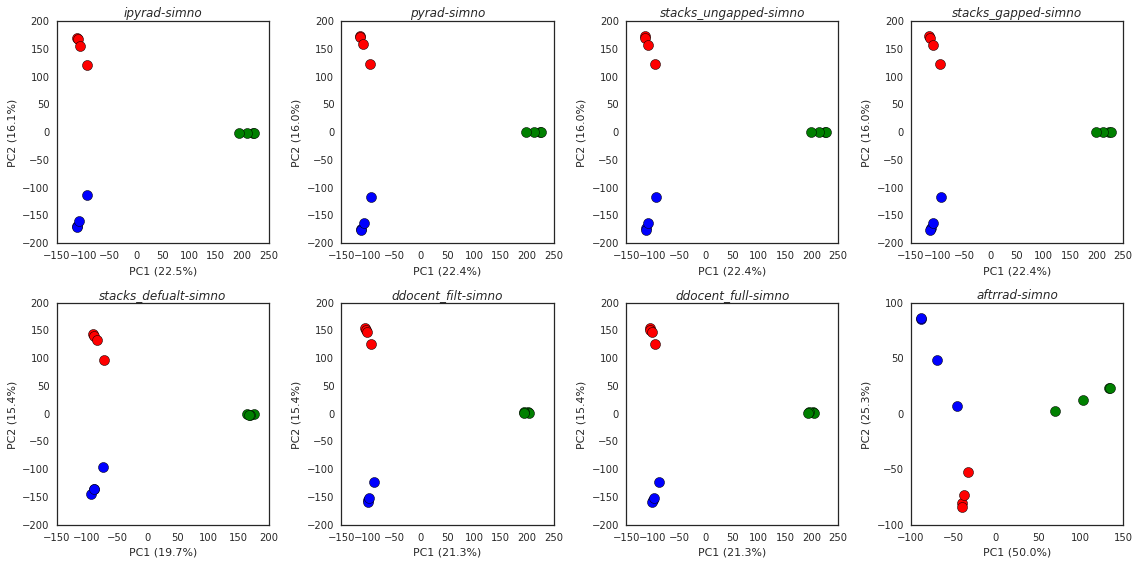

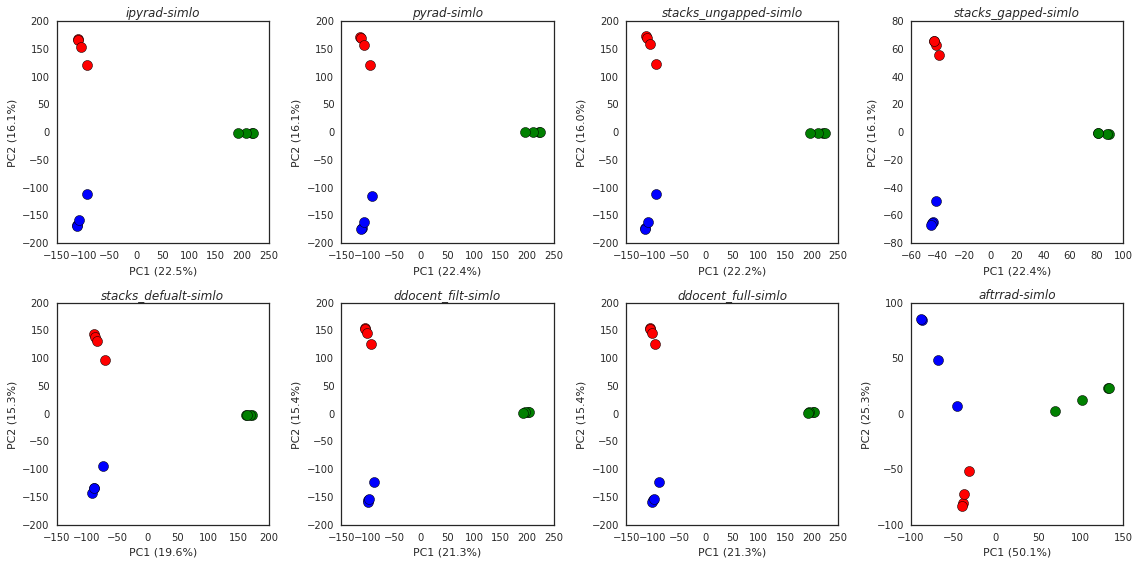

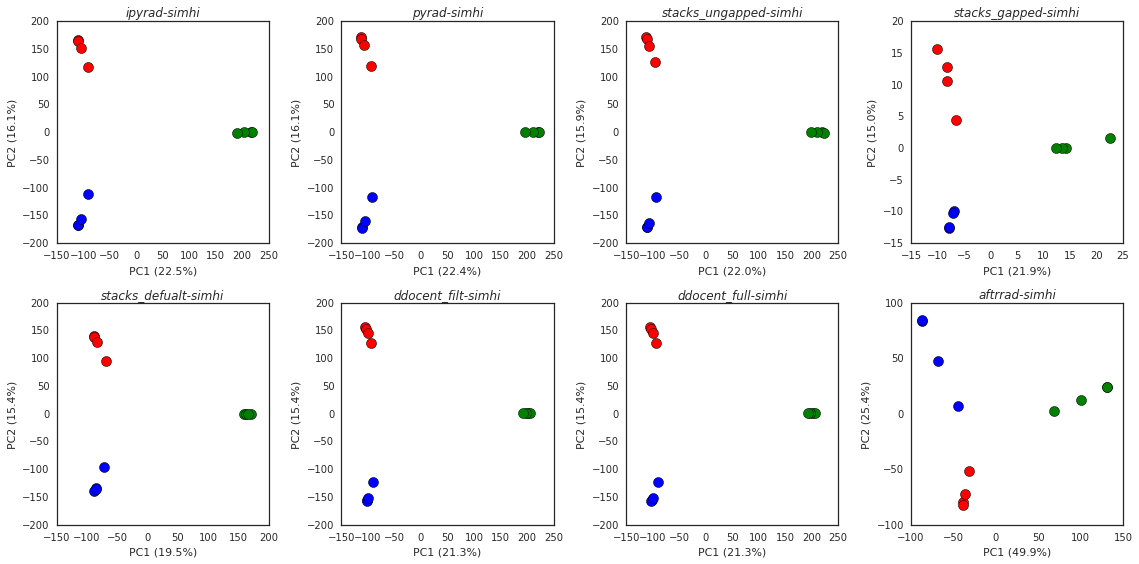

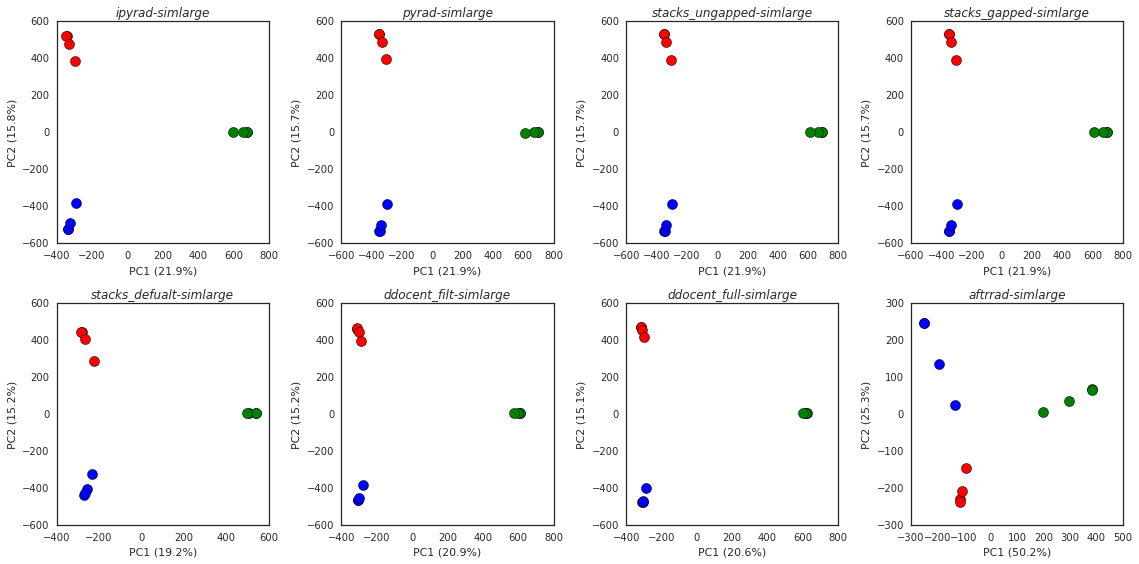

In [619]:
## Some housekeeping with sample names to make the PCA plots prettier
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]
pops = {"pop1":pop1, "pop2":pop2, "pop3":pop3}
pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}
sim_sample_names = pop1 + pop2 + pop3

for sim in ["-simno", "-simlo", "-simhi", "-simlarge"]:
#for sim in ["-simhi"]:
    print("Doing - {}".format(sim))
    f, axarr = plt.subplots(2, 4, figsize=(16,8), dpi=1000)
    axarr = [a for b in axarr for a in b]

    for prog, ax in zip(["ipyrad", "pyrad", "stacks_ungapped", "stacks_gapped", \
                              "stacks_defualt", "ddocent_filt", "ddocent_full", "aftrrad"], axarr):
        ## Annoying debug messages
        #print("{}".format(prog+sim)),
        #print("{}".format(sim_vcf_dict[prog+sim]))

        coords1, model1 = getPCA(calldata[prog+sim])

        x = coords1[:, 0]
        y = coords1[:, 1]

        ax.scatter(x, y, marker='o')
        ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
        ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))

        for pop in pops.keys():
            flt = np.in1d(np.array(sim_sample_names), pops[pop])
            ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)
    
        ax.set_title(prog+sim, style="italic")
        ax.axison = True
    f.tight_layout()

### Plot pairwise distances for each assembler and each simulated datatype

Doing - -simno
ipyrad-simno /home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simno/simno_outfiles/simno-biallelic.recode.vcf
pyrad-simno /home/iovercast/manuscript-analysis/pyrad/SIMDATA/simno/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf
stacks_ungapped-simno /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simno/batch_1-biallelic.recode.vcf
stacks_gapped-simno /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/simno/batch_1-biallelic.recode.vcf
stacks_defualt-simno /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/simno/batch_1-biallelic.recode.vcf
ddocent_filt-simno /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/Final.recode-biallelic.recode.vcf
ddocent_full-simno /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/TotalRawSNPs-biallelic.recode.vcf
aftrrad-simno /home/iovercast/manuscript-analysis/aftrRAD/SIMDATA/simno/Formatting/simno-biallelic.recode.vcf
Doing - -simlo
ipyrad-simlo /home/iovercast/manuscript-ana

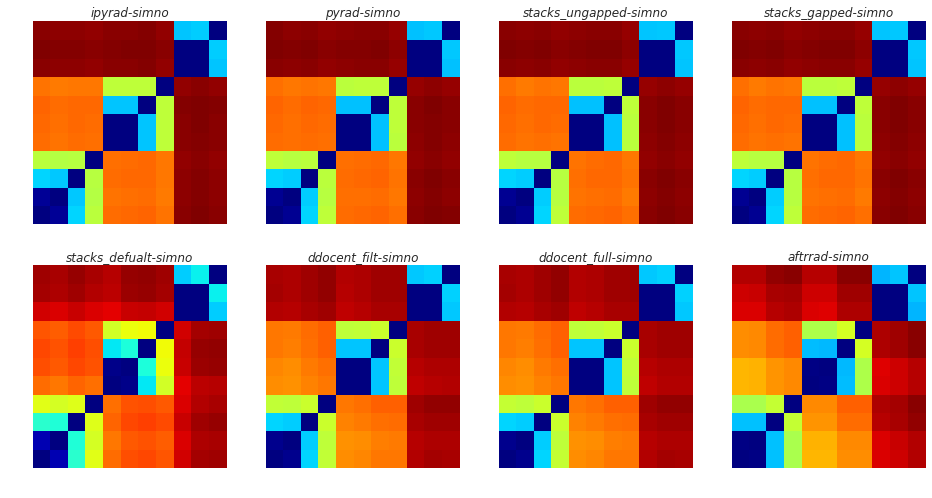

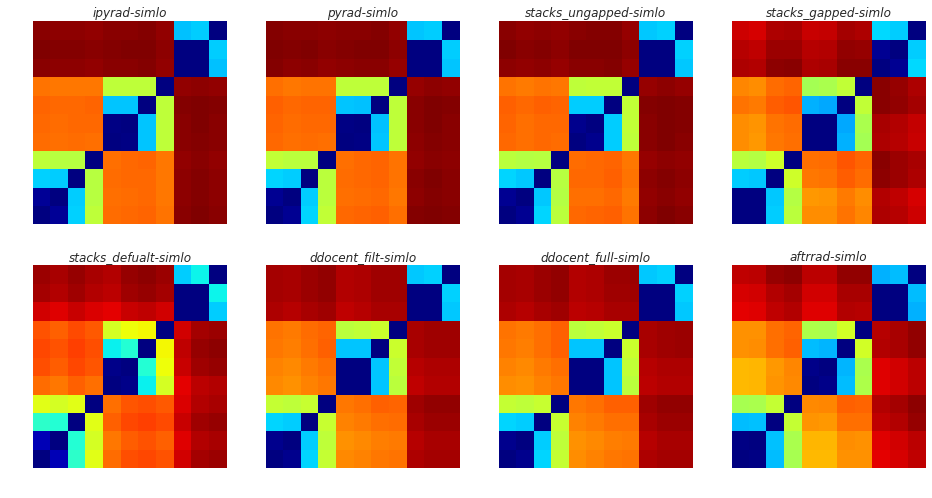

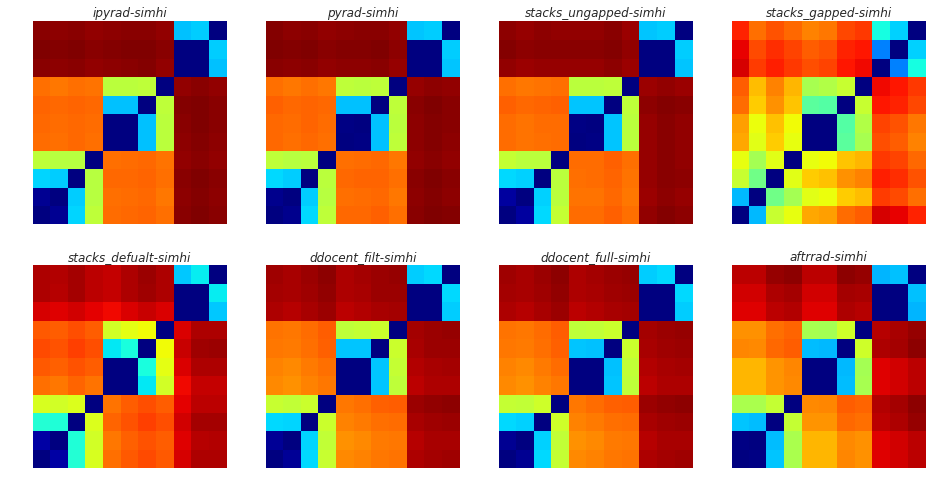

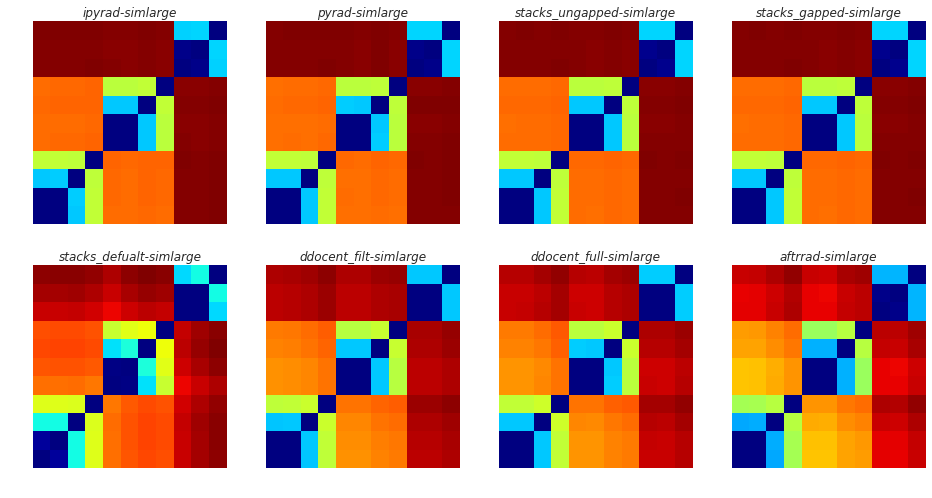

In [65]:
for sim in ["-simno", "-simlo", "-simhi", "-simlarge"]:
#for sim in ["-simhi"]:
    print("Doing - {}".format(sim))
    f, axarr = plt.subplots(2, 4, figsize=(16,8), dpi=1000)
    axarr = [a for b in axarr for a in b]

    for prog, ax in zip(["ipyrad", "pyrad", "stacks_ungapped", "stacks_gapped", \
                              "stacks_defualt", "ddocent_filt", "ddocent_full", "aftrrad"], axarr):
        print("{}".format(prog+sim)),
        print("{}".format(sim_vcf_dict[prog+sim]))

        ## Calculate pairwise distances
        dist = getDistances(calldata[prog+sim])

        ## Doing it this way works, but allel uses imshow internally which rasterizes the image
        #allel.plot.pairwise_distance(dist, labels=None, ax=ax, colorbar=False)

        ## Create the pcolormesh by hand
        dat = ensure_square(dist)
        
        ## for some reason np.flipud(dat) is chopping off one row of data
        p = ax.pcolormesh(np.arange(0,len(dat[0])), np.arange(0,len(dat[0])), dat,\
        cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
        ## Clip all heatmaps to actual sample size
        p.axes.axis("tight")
    
        ax.set_title(prog+sim, style="italic")
        ax.axison = False


# Go through and pull in more fine grained results
What we want to know is total number of loci recovered (not just variable loci). First we'll create some dictionaries just like above, but we'll call them *_full_* to indicate that they include monomorphic sites. Because snps don't occur in monomorphic sites kind of by definition, we only really are iterested in the depth across loci and the number of loci recovered per sample.


In [71]:
sim_full_loc_cov = collections.OrderedDict()
sim_full_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in sim_vcf_dict.items():
    print("Doing - {}\t".format(prog)),
    sim_full_loc_cov[prog] = []
    sim_full_sample_nlocs[prog] = []

Doing - ipyrad-simlarge	Doing - pyrad-simhi	Doing - pyrad-simlo	Doing - ddocent_full-simlarge	Doing - ddocent_filt-simlo	Doing - stacks_gapped-simno	Doing - stacks_ungapped-simlarge	Doing - aftrrad-simno	Doing - aftrrad-simlo	Doing - ddocent_filt-simno	Doing - stacks_gapped-simlo	Doing - ipyrad-simlo	Doing - stacks_defualt-simhi	Doing - ddocent_filt-simlarge	Doing - stacks_gapped-simhi	Doing - ipyrad-simno	Doing - aftrrad-simlarge	Doing - stacks_ungapped-simhi	Doing - aftrrad-simhi	Doing - stacks_ungapped-simno	Doing - stacks_defualt-simlarge	Doing - stacks_ungapped-simlo	Doing - ipyrad-simhi	Doing - pyrad-simno	Doing - ddocent_full-simhi	Doing - stacks_defualt-simno	Doing - pyrad-simlarge	Doing - ddocent_full-simlo	Doing - stacks_gapped-simlarge	Doing - stacks_defualt-simlo	Doing - ddocent_filt-simhi	Doing - ddocent_full-simno	

## ipyrad simulated results

In [407]:
## ipyrad stats
IPYRAD_SIMOUT=os.path.join(IPYRAD_DIR, "SIMDATA/")
for sim in ["simno", "simlo", "simhi", "simlarge"]:
    print("Doing - {}\t".format(sim)),
    simstring = "ipyrad-" + sim
    simdir = os.path.join(IPYRAD_SIMOUT, sim)
    statsfile = simdir + "/{}_outfiles/{}_stats.txt".format(sim, sim)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[20:32]]
    #print(sample_coverage)
    print("mean sample coverage - {}\t".format(np.mean(sample_coverage))),
    print("min/max - {}/{}\t".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_full_sample_nlocs[simstring] = sample_coverage
    
    nmissing = [int(x.strip().split()[1]) for x in infile[38:50]]
    sim_full_loc_cov[simstring] = nmissing

## Just look at the ones we care about for ipyrad
print([(x,y) for x,y in sim_full_loc_cov.items() if "ipyrad" in x])
print([(x,y) for x,y in sim_full_sample_nlocs.items() if "ipyrad" in x])

Doing - simno	mean sample coverage - 10000.0	min/max - 10000/10000	
Doing - simlo	mean sample coverage - 10000.0	min/max - 10000/10000	
Doing - simhi	mean sample coverage - 9999.91666667	min/max - 9999/10000	
Doing - simlarge	mean sample coverage - 96942.6666667	min/max - 96917/96986	
[('ipyrad-simlarge', [0, 27, 61, 600, 158, 80, 274, 1851, 1742, 2385, 10113, 82659]), ('ipyrad-simlo', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad-simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad-simhi', [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 9998]), ('ipyrad_simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad_simlo', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad_simhi', [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 9998]), ('ipyrad_simlarge', [0, 27, 61, 600, 158, 80, 274, 1851, 1742, 2385, 10113, 82659])]
[('ipyrad-simlarge', [96923, 96959, 96931, 96986, 96972, 96933, 96958, 96945, 96917, 96928, 96926, 96934]), ('ipyrad-simlo', [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 100

## pyrad simulated results

In [406]:
## ipyrad stats
PYRAD_SIMOUT=os.path.join(PYRAD_DIR, "SIMDATA/")
for sim in ["simno", "simlo", "simhi", "simlarge"]:
    simstring = "pyrad-"+sim
    print("Doing - {}\t".format(sim)),
    simdir = os.path.join(PYRAD_SIMOUT, sim)
    statsfile = simdir + "/stats/c85d6m2p3H3N3.stats"
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[8:20]]
    print("mean sample coverage - {}\t".format(np.mean(sample_coverage))),
    print("min/max - {}/{}\t".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_full_sample_nlocs[simstring] = sample_coverage
    
    nmissing = [0] + [int(x.strip().split()[1]) for x in infile[26:37]]
    sim_full_loc_cov[simstring] = nmissing

## Just look at the ones we care about for pyrad
print([(x,y) for x,y in sim_full_loc_cov.items() if "pyrad" in x])
print([(x,y) for x,y in sim_full_sample_nlocs.items() if "pyrad" in x])

Doing - simno	mean sample coverage - 10000.0	min/max - 10000/10000	
Doing - simlo	mean sample coverage - 10000.0	min/max - 10000/10000	
Doing - simhi	mean sample coverage - 9999.91666667	min/max - 9999/10000	
Doing - simlarge	mean sample coverage - 96943.6666667	min/max - 96918/96987	
[('ipyrad-simlarge', []), ('pyrad-simhi', [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 9998]), ('pyrad-simlo', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad-simlo', []), ('ipyrad-simno', []), ('ipyrad-simhi', []), ('pyrad-simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('pyrad-simlarge', [0, 27, 61, 600, 158, 80, 274, 1851, 1742, 2385, 10113, 82660]), ('ipyrad_simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad_simlo', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('ipyrad_simhi', [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 9998]), ('ipyrad_simlarge', [0, 27, 61, 600, 158, 80, 274, 1851, 1742, 2385, 10113, 82659]), ('pyrad_simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000]), ('pyrad_simlo', [0, 0, 0, 0, 0, 0, 0, 0

## stacks simulated results

In [111]:
import gzip

## stacks stats
STACKS_SIMOUT=os.path.join(STACKS_DIR, "SIMDATA/")
STACKS_GAP_SIMOUT=os.path.join(STACKS_SIMOUT, "gapped/")
STACKS_UNGAP_SIMOUT=os.path.join(STACKS_SIMOUT, "ungapped/")
STACKS_DEFAULT_SIMOUT=os.path.join(STACKS_SIMOUT, "default/")

for dir in [STACKS_GAP_SIMOUT, STACKS_UNGAP_SIMOUT, STACKS_DEFAULT_SIMOUT]:
    stacks_method = dir.split("/")[-2]
    for sim in ["simno", "simlo", "simhi", "simlarge"]:
        #print("Doing - {}-{}".format(stacks_method, sim)),
        simstring = "stacks_"+stacks_method+"-"+sim
        try:
            simdir = os.path.join(dir, sim)
            lines = open("{}/batch_1.haplotypes.tsv".format(simdir)).readlines()
            cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
            sim_full_loc_cov[simstring] = [cnts.count(i) for i in range(1,13)]
        except Exception as inst:
            print("loc_cov - {} - {}".format(inst, simdir))

        try:
            sim_full_sample_nlocs[simstring] = []
            samp_haps = glob.glob("{}/*matches*".format(simdir))
            for f in samp_haps:
                lines = gzip.open(f).readlines()
                sim_full_sample_nlocs[simstring].append(len(lines) - 1)
        except Exception as inst:
            print("sample_nlocs - {} - {}".format(inst, simdir))
## Just look at the stacks results to reduce the clutter
print([(x,y) for x,y in sim_full_loc_cov.items() if "stacks" in x])
print([(x,y) for x,y in sim_full_sample_nlocs.items() if "stacks" in x])

[('stacks_gapped-simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 336, 9652]), ('stacks_ungapped-simlarge', [49, 29, 67, 593, 156, 92, 311, 1840, 1767, 2674, 12583, 79747]), ('stacks_gapped-simlo', [19, 5, 1, 3, 1, 1, 1, 1, 1, 15, 348, 9623]), ('stacks_defualt-simhi', []), ('stacks_gapped-simhi', [241, 28, 25, 28, 5, 1, 4, 29, 21, 39, 506, 9387]), ('stacks_ungapped-simhi', [1322, 174, 123, 148, 19, 13, 21, 148, 112, 137, 956, 8611]), ('stacks_ungapped-simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 336, 9652]), ('stacks_defualt-simlarge', []), ('stacks_ungapped-simlo', [589, 79, 54, 56, 7, 2, 8, 52, 50, 67, 584, 9231]), ('stacks_defualt-simno', []), ('stacks_gapped-simlarge', [49, 29, 67, 593, 156, 92, 311, 1840, 1767, 2674, 12583, 79747]), ('stacks_defualt-simlo', []), ('stacks_default-simno', [3307, 709, 652, 748, 85, 66, 175, 727, 332, 353, 1349, 6446]), ('stacks_default-simlo', [3868, 754, 699, 773, 92, 73, 200, 749, 354, 387, 1488, 6207]), ('stacks_default-simhi', [4592, 837, 740, 833, 105, 90, 239,

## AftrRAD simulated results
AftrRAD doesn't natively support vcf. the vcf files we made
are in sim\*/Formatting/sim\*.vcf

It's not straightforward how to get the locations for snps
from the output files. aftrRAD does calculate and write these out
as part of the Genotype.pl phase to a file called __/TempFiles/SNPLocationsToPlot.txt__

It's also not straightforward how to get the number of loci recovered for each invidual.
You have to total up the counts from two different files for each individual. The
`Outputs/Genotypes` directory has two files, one for `Haplotypes` and one for `Monomorphics`.
The haplotypes file is a giant matrix of concatenated snps per locus so you have to 
search through each column to count up all the `NA`'s (missing data per locus per individual).
Then you have to count up the number of non-zero monomorphic sites.

In [192]:
AFTRRAD_SIMOUT=os.path.join(AFTRRAD_DIR, "SIMDATA/")
for sim in ["simno", "simlo", "simhi", "simlarge"]:
#for sim in ["simlo"]:
    simstring = "aftrrad-{}".format(sim)
    print("Doing - {}".format(simstring))
    simdir = os.path.join(AFTRRAD_SIMOUT, sim)
    ## The `17` in the file name is the min % of samples w/ data
    hapsfile = simdir + "/Output/Genotypes/Haplotypes_17.All.txt"
    monofile = simdir + "/Output/Genotypes/Monomorphics_17.txt"

    ## Set low_memory=False or else simlarge crashes pandas
    mono_df = pd.read_csv(monofile, delim_whitespace=True, header=0, low_memory=False)
    haps_df = pd.read_csv(hapsfile, delim_whitespace=True, header=0, index_col=0, low_memory=False)

    sample_coverage = {}
    ## Get the list of all the simulated sample names
    samplenames = mono_df.columns.values[1:]
    ## Do haplotypes file first because it is phased so there are 2 rows per sample
    ## so we end up double counting NA's. If you read the # of monomorphics first
    ## then you have to figure out some way to prevent the double counting, here
    ## we just count twice and overwrite.
    for row in haps_df.itertuples():        
        sample_coverage[row[0].split("Individual")[1]] = len(pd.Series(row).nonzero()[0])

    for sname in samplenames:
        ## nonzero returns a tuple of which we are only interested in the first element
        sample_coverage[sname] += len(mono_df[sname].nonzero()[0])

    ## To sort or not to sort the coverage_df?
    print("mean sample coverage - {}".format(np.mean(sample_coverage.values()))),
    print("min/max - {}/{}".format(np.min(sample_coverage.values()), np.max(sample_coverage.values())))

    ## Put them in the dict sorted by sample name
    sim_full_sample_nlocs[simstring] = [sample_coverage[x] for x in sorted(sample_coverage.keys())]

    ## Now do locus coverage
    ## For the same reason as above, do the haplotypes file first. We create the tmp_counts
    ## counter and then make a new counter with the index being 1/2 to account for the
    ## doublecounting of NaN in the haplotypes file.
    ## Also, note that annoyingly pandas reads in "NA" as float('nan') rather than string "NA"
    ## which took me a _while_ to figure out.
    hap_nonzero = collections.Counter(haps_df.count())
    tmp_counts = collections.Counter(hap_nonzero)
    hap_counts = collections.Counter()
    for x in tmp_counts:
        hap_counts.update({x/2:tmp_counts[x]})

    ## Get monomorphics
    ## Get the sum of non-zero elements per row (the fancy .ix slicing drops the 
    ## first column which is the sequence)
    mono_nonzero = (mono_df.ix[:, 1:] != 0).astype(int).sum(axis=1)
    mono_counts = collections.Counter(mono_nonzero)

    tot_counts = hap_counts + mono_counts
    ## Collections are unordered, and also any coverage level with no count
    ## will not be in the collection, so we have to order it and insert zeros at the appropriate locations
    dat = []
    for i in xrange(1,13):
        try:
            dat.append(tot_counts[i])
        except:
            dat.append(0)
    sim_full_loc_cov[simstring] = dat

print("Locus coverage")
print([(x,y) for x,y in sim_full_loc_cov.items() if "aftrrad" in x])
print("Sample nloci")
print([(x,y) for x,y in sim_full_sample_nlocs.items() if "aftrrad" in x])

 Doing - aftrrad-simlarge mean sample coverage aftrrad-simlarge - 100172.75 min/max - 100132/100249
Locus coverage
[('aftrrad-simno', [0, 1, 17, 29, 5, 1, 3, 27, 15, 9, 36, 9910]), ('aftrrad-simlo', [0, 3, 20, 37, 7, 0, 4, 34, 18, 16, 58, 9870]), ('aftrrad-simlarge', [0, 19, 226, 838, 213, 117, 332, 2078, 1878, 2529, 10526, 81656]), ('aftrrad-simhi', [0, 11, 35, 57, 5, 1, 5, 53, 30, 22, 129, 9761])]
Sample nloci
[('aftrrad-simno', [10051, 10051, 10051, 10051, 10050, 10050, 10050, 10050, 10052, 10053, 10053, 10052]), ('aftrrad-simlo', [10059, 10060, 10058, 10059, 10059, 10059, 10059, 10058, 10061, 10062, 10062, 10059]), ('aftrrad-simlarge', [100138, 100141, 100137, 100135, 100141, 100134, 100137, 100132, 100244, 100244, 100249, 100241]), ('aftrrad-simhi', [10088, 10089, 10083, 10082, 10087, 10085, 10082, 10081, 10089, 10090, 10087, 10085])]


## dDocent simulated results
~~Here's what's weird. The dDocent reference.fasta file which is generated by the cd-hit clustering looks like it contains the right number of clusters. Similarly, if you use samtools to view the sample `-RG.bam`, and the `mapped.bed` file has 10000 loci as well. But if you look at the Contigs that make it to the final vcf files (either TotalRawSNPs or Final.recode) there are ~100+ contigs missing. I'm sure freebayes is filtering loci, but i diff'd the loci in the bed file and the vcf, and looked at the sequences of one of the missing loci in the cat-RRG.bam file and they look more or less normal. It's not the mapping quality flaq (-m), because all sim seqs have high quality mapping. None of the other settings in the dDocent script or the default freebayes settings seem particularly conspicuous.~~ Monomorphic loci obviously aren't going to end up in the final vcf. It is incredibly not straightforward how to actually get access to the monomorphic loci from the intermediary files that dDocent creates. The shortcuts that dDocent takes to run super fast mean it's really hard to get "stacks" of sequence data per locus (e.g. the ipyrad .loci file). 

        grep Contig TotalRawSNPs.vcf | cut -f 1 | uniq -c | wc -l
        
simno/simlo/simhi - 9887/9889/9890

For simlarge there was a much bigger difference between the TotalRaw and Final.recode vcf files (98350/91620), TotalRaw recovers about 98.4% of true loci, but the final recode catches only about 92%.

It's also not super straightforward how to get # loci per sample from the dDocent output, so 
I had to gin something up. Right now because it uses samtools to view the bam file and then does
some shell manipulation, this is a little slow (20 seconds per simulation treatment), but tolerable.

TODO: This is currently not tracking __which__ samples correspond with the number of loci recovered
bcz the ddocent bam files use the weird naming scheme and I haven't back calculated the good names yet.

This isn't exactly technically correct, because this is the counts of loci mapped for each individual,
not the number of loci for each individual in the output!

Also, this is a little slow. Takes about 30-40 minutes.

In [ ]:
import subprocess

DDOCENT_SIMOUT=os.path.join(DDOCENT_DIR, "SIMDATA/")
for sim in ["simno", "simlo", "simhi", "simlarge"]:
#for sim in ["simlo"]:
    simdir = os.path.join(DDOCENT_SIMOUT, sim + "/" + sim + "_fastqs/")
    print("Doing {} - {}".format(sim, simdir))

    ## This is hackish. You have to dip into the bam file to get locus counts that
    ## include counts for monomorphics. Note! that field 3 of the bam file is not
    ## the sequence data, but rather the dDocent mock-contig ('dDocent_Contig_3') 
    ## the read maps to. So really this is kind of by proxy counting the number of loci.
    sample_coverage = []
    for samp in glob.glob(simdir + "/*-RG.bam"):
        cmd = "{}samtools view {} | cut -f 3 | uniq | wc -l".format(DDOCENT_DIR, samp)
        res = subprocess.check_output(cmd, shell=True)
        sample_coverage.append(int(res.strip()))
    print("This must be taken with a grain of salt because these aren't the actual counts you get out of the final data files.")
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
    
    print("Reading VCF")
    vcf_filt = pd.read_csv("{}/Final.recode.vcf".format(simdir), delim_whitespace=True, header=60, index_col=0)
    vcf_full = pd.read_csv("{}/TotalRawSNPs.vcf".format(simdir), delim_whitespace=True, header=60, index_col=0)

    for vcf_string, vcf_df in zip(["full", "filt"], [vcf_full, vcf_filt]):
        simstring = "ddocent_" + vcf_string + "-" + sim
        print("Doing {}".format(simstring))
        ## Sample coverage is the same for both conditions here, because they are based on the
        ## same raw data.
        idxs = set(vcf_df.index)

        ## Here we are going to simultaneously accumulate information about nloci per sample and locus coverage counts.
        c = []
        sample_cov_counter = collections.Counter()
        for i, idx in enumerate(idxs):
            ## Poor man's progress bar. For the impatient.
            if not i % 1000:
                print(i),

            ## Complicated song and dance here because if the locus only has one snp you have to do
            ## some bullshit to reshape the dataframe.
            tmp_df = vcf_df.loc[idx]
            if isinstance(tmp_df, pd.Series):
                tmp_df = tmp_df.to_frame().T
                
            ## The double apply is applying split() to all rows and columns to get the genotype data
            nonzero_samps = (tmp_df.iloc[:, 8:20].apply(lambda x: x.apply(lambda y: y.split(":")[0])) != "./.").\
                              astype(int).sum().nonzero()[0]
            sample_cov_counter.update(nonzero_samps)
            c.append(len(nonzero_samps))
                
            ## The double apply is applying split() to all rows and columns to get the genotype data
#            count = len((tmp_df.iloc[:, 8:20].\
#                apply(lambda x: x.apply(lambda y: y.split(":")[0])) != "./.").astype(int).sum().nonzero()[0])
#            c.append(count)
        counts = collections.Counter(c)

        ## Fill in zero values that aren't in the locus counter
        dat = []
        for i in xrange(1,13):
            try:
                dat.append(counts[i])
            except:
                dat.append(0)

        sim_full_loc_cov[simstring] = dat
        sim_full_sample_nlocs[simstring] = sample_cov_counter.values()

# Here's a different stupid way to do this...
#
#        sample_counts = {}
#        sample_names = list(vcf.columns)[8:]
#        print(sample_names)
#        print("num loci - {}".format(len(set(vcf.index))))
#        for name in sample_names:
#            print(name)
#            sample_counts[name] = 0
#            for locus in set(vcf.index):
#                snps = vcf[name][locus]
#                if any(map(lambda x: x.split(":")[0] != "./.", snps)):
#                    sample_counts[name] += 1
#                else:
#                    pass
#                    #print("{} {} {}".format(name, locus, snps))
#        print(sample_counts)

    print("Locus coverage")
    print([(x,y) for x,y in sim_full_loc_cov.items() if "ddocent" in x])
    print("Sample nloci")
    print([(x,y) for x,y in sim_full_sample_nlocs.items() if "ddocent" in x])

Doing simno - /home/iovercast/manuscript-analysis/dDocent/SIMDATA/simno/simno_fastqs/
This must be taken with a grain of salt because these aren't the actual counts you get out of the final data files.
mean sample coverage - 10000.0
min/max - 10000/10000
Reading VCF
Doing ddocent_full-simno
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 Doing ddocent_filt-simno
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 Locus coverage
[('ddocent_full-simlarge', []), ('ddocent_filt-simlo', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9888]), ('ddocent_filt-simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9886]), ('ddocent_filt-simlarge', []), ('ddocent_full-simhi', [0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 4, 9881]), ('ddocent_full-simlo', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9888]), ('ddocent_filt-simhi', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 9881]), ('ddocent_full-simno', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9886])]
Sample nloci
[('ddocent_full-simlarge', []), ('ddocent_filt-simlo', []), ('ddocent_filt-simno', [9886, 9886, 9886, 9886, 

### Write out results of the simulations
This data is worth its weight in gold, it takes forever to acquire,
so lets save it off to disk so we don't lose it.

In [502]:
import pickle
sim_res_dict = {"sim_sample_nlocs_df":sim_full_sample_nlocs, "sim_full_loc_cov":sim_full_loc_cov}

for k,v in sim_res_dict.items():
    print(k)
    pickle.dump(v, open(WORK_DIR + "RESULTS/" + k + ".p", 'wb'))

sim_full_loc_cov
sim_sample_nlocs_df


## Plotting simulation results

Mean number of loci recovered per sample.
                   simno    simlo    simhi simlarge
ipyrad             10000    10000  9999.92  96942.7
pyrad              10000    10000  9999.92  96943.7
stacks_gapped    11422.7  11393.8  11364.8   110707
stacks_ungapped  11422.7  11423.9  11420.8   110707
stacks_default   11079.2  11091.1  11101.2   107224
aftrrad          10051.2  10059.6  10085.7   100173
ddocent_full        9886     9888  9886.58  95584.8
ddocent_filt        9886     9888  9884.67  90797.9


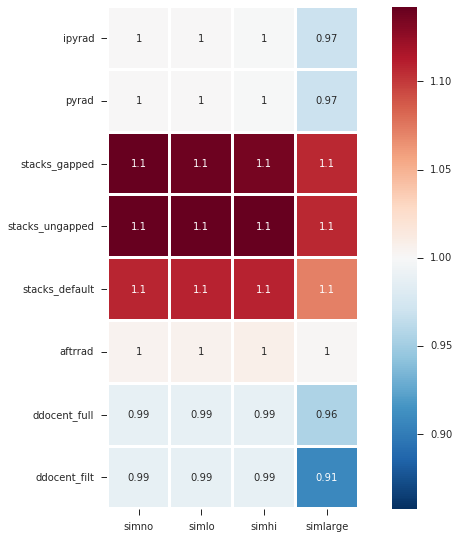

In [443]:
simlevel = ["simno", "simlo", "simhi", "simlarge"]
assemblers = ["ipyrad", "pyrad", "stacks_gapped", "stacks_ungapped",\
              "stacks_default", "aftrrad", "ddocent_full", "ddocent_filt"]

sim_sample_nlocs_df = pd.DataFrame(index=assemblers, columns=simlevel)

for sim in simlevel:
    for ass in assemblers:
        simstring = "-".join([ass, sim])
        sim_sample_nlocs_df[sim][ass] = np.mean(sim_full_sample_nlocs[simstring])
print("Mean number of loci recovered per sample.")
## Normalize all bins
dat = sim_sample_nlocs_df[sim_sample_nlocs_df.columns].astype(float)
for sim in simlevel:
    scale = 10000
    if sim == "simlarge":
        scale = 100000
    dat[sim] = dat[sim]/scale
sns.heatmap(dat, square=True, center=1, linewidths=2, annot=True)
print(sim_sample_nlocs_df)
#print(dat)

### Ugly plot for locus coverage. 

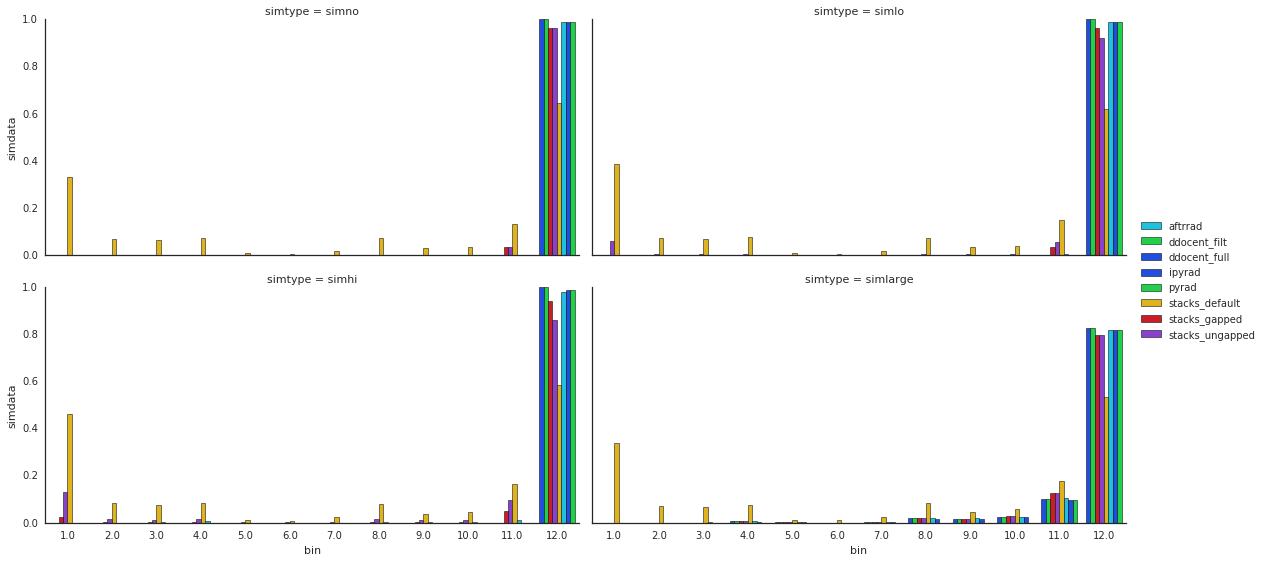

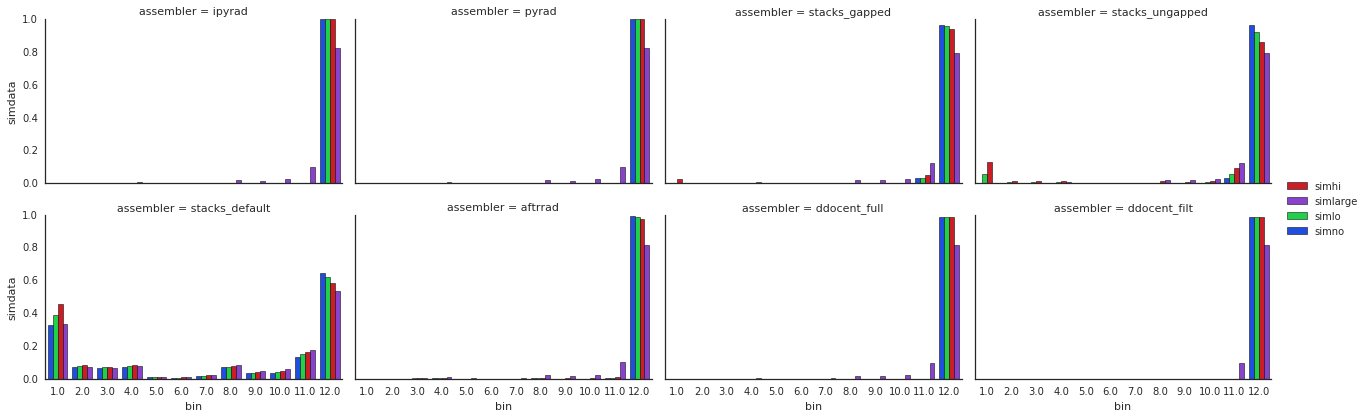

In [552]:
simlevel = ["simno", "simlo", "simhi", "simlarge"]
assemblers = ["ipyrad", "pyrad", "stacks_gapped", "stacks_ungapped",\
              "stacks_default", "aftrrad", "ddocent_full", "ddocent_filt"]
df = pd.DataFrame(index=assemblers, columns=simlevel)
df2 = pd.DataFrame(columns = ["assembler", "simtype"] + [x for x in xrange(1,13)])
df3 = pd.DataFrame(columns = ["assembler", "simtype", "simdata"])
## Try to get a dataframe in the shape seaborn will be happy with
dfsns = pd.DataFrame(columns = ["assembler", "simtype", "bin", "simdata"])

for sim in simlevel:
    for ass in assemblers:
        simstring = ass + "-" + sim
        df[sim][ass] = np.array(sim_full_loc_cov[simstring])
        df2.loc[simstring] = [ass, sim] + sim_full_loc_cov[simstring]
        df3.loc[simstring] = [ass, sim, np.array(sim_full_loc_cov[simstring])]

        for i, val in enumerate(sim_full_loc_cov[simstring]):
            ## Normalize values so different sim sizes print the same
            max = 10000.
            if "large" in simstring:
                max = 100000.
            dfsns.loc[simstring + "-" + str(i)] = [ass, sim, i+1, val/max]

sns.set(style="white")

## This kinda sucks, too spread out.
#g = sns.FacetGrid(dfsns, row="assembler", col="simtype", margin_titles=True)
#g.map(sns.barplot, "bin", "simdata", color="steelblue", lw=0)
plt.rcParams['figure.figsize']=(20,20)
g = sns.FacetGrid(dfsns, col="simtype", margin_titles=True, col_wrap=2, size=4, aspect=2)
g.map(sns.barplot, "bin", "simdata", "assembler", lw=0.5, palette="bright").add_legend()

### Another ugly plot for locus coverage. 

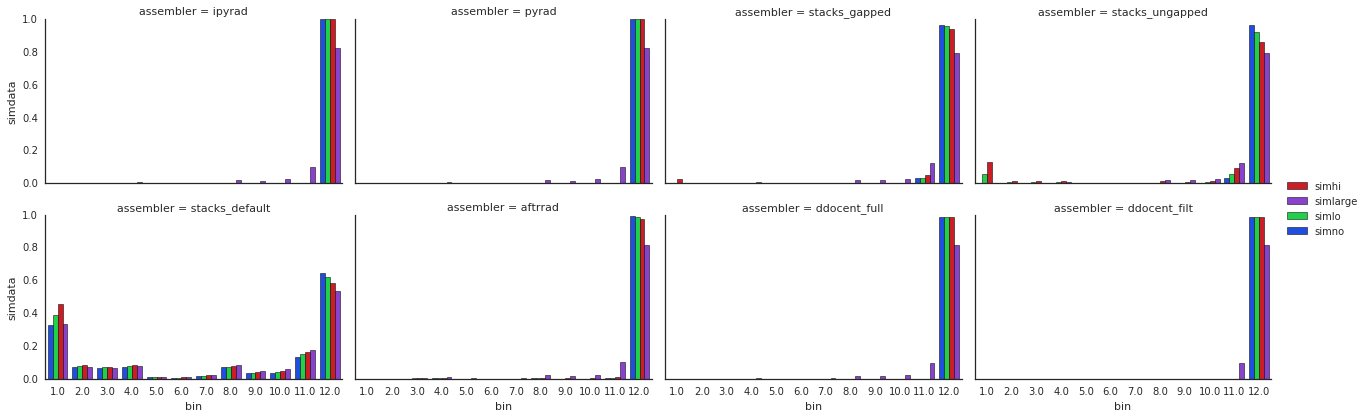

In [553]:
## Barplots of assembly method x simdata type
g = sns.FacetGrid(dfsns, col="assembler", margin_titles=True, col_wrap=4, size=3, aspect=1.5)
g.map(sns.barplot, "bin", "simdata", "simtype", lw=0.5, palette="bright").add_legend()

### Much better! Do the spline plot version of the above plot
It just looks nicer, makes more sense.

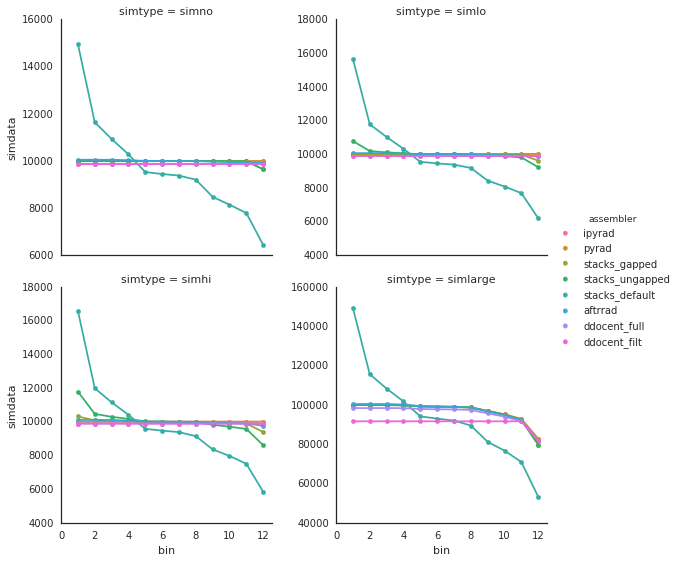

In [598]:
dfsns2 = pd.DataFrame(columns = ["assembler", "simtype", "bin", "simdata"])


for sim in simlevel:
    for ass in assemblers:
        simstring = ass + "-" + sim
        ## Normalize values so different sim sizes print the same
        max = 10000.
        if "large" in simstring:
            max = 100000.
        
        newdat = sim_full_loc_cov[simstring]
        newdat = [sum(newdat)-sum(newdat[:i-1]) for i in range(1,13)]
        for i, val in enumerate(newdat):
            dfsns2.loc[simstring + "-" + str(i)] = [ass, sim, i+1, val]

g = sns.FacetGrid(dfsns2, col="simtype", hue="assembler", sharex=True, sharey=False, size=4, col_wrap=2)
g.map(plt.scatter, "bin", "simdata")
g.map(plt.plot, "bin", "simdata").add_legend()
axs = g.axes
for ax in axs:
    ax.set_xlim(0,12.5)

# Empirical Results (Pedicularis)

## Process the vcf output from all the runs
Here we'll pull together all the output vcf files and filter
out everything except biallelic snps. This takes a few minutes to run.

In [603]:
vcf_dict = {}
vcf_dict["ipyrad"] = os.path.join(IPYRAD_DIR, "REALDATA/REALDATA_outfiles/REALDATA.vcf")
vcf_dict["pyrad"] = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
vcf_dict["stacks_ungapped"] = os.path.join(STACKS_DIR, "REALDATA/ungapped/batch_1.vcf")
vcf_dict["stacks_gapped"] = os.path.join(STACKS_DIR, "REALDATA/gapped/batch_1.vcf")
vcf_dict["stacks_default"] = os.path.join(STACKS_DIR, "REALDATA/default/batch_1.vcf")
vcf_dict["aftrrad"] = os.path.join(AFTRRAD_DIR, "REALDATA/Formatting/REALDATA.vcf")
vcf_dict["ddocent_full"] = os.path.join(DDOCENT_DIR, "REALDATA/TotalRawSNPs.vcf")
vcf_dict["ddocent_filt"] = os.path.join(DDOCENT_DIR, "REALDATA/Final.recode.vcf")
for k, f in vcf_dict.items():
    if os.path.exists(f):
        print("found - {}".format(f))
        
        ## If it's gzipped then unzip it (only applies to ipyrad i think)
        if ".gz" in f:
            print("gunzipping")
            cmd = "gunzip {}".format(f)
            !cmd
            vcf_dict[k] = f.split(".gz")[0]
            
        ## Remove all but biallelic (for ipyrad this also removes all the monomorphic)
        #outfile = f.split(".vcf")[0]+"-biallelic"
        #cmd = "{}vcftools --vcf {} --min-alleles 2 --max-alleles 2 --recode --out {}" \
        #    .format(DDOCENT_DIR, f, outfile)
        #print(cmd)
        #!$cmd
        
        ## update the vcf_dict
        #vcf_dict[k] = outfile + ".recode.vcf"
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1.vcf
/home/iovercast/manuscript-analysis/dDocent/vcftools --vcf /home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1.vcf --min-alleles 2 --max-alleles 2 --recode --out /home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1-biallelic

VCFtools - v0.1.11
(C) Adam Auton 2009

Parameters as interpreted:
	--vcf /home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1.vcf
	--max-alleles 2
	--min-alleles 2
	--out /home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1-biallelic
	--recode

Reading Index file.
File contains 149570 entries and 13 individuals.
Applying Required Filters.
Filtering sites by number of alleles
After filtering, kept 13 out of 13 Individuals
After filtering, kept 149570 out of a possible 149570 Sites
Outputting VCF file... Done
Run Time = 5.00 seconds
found - /home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPs.vcf
/home/iovercast/m

## Read in vcf for each analysis and pull in coverage/depth stats

[vcfnp] 2016-10-18 11:08:57.760390 :: caching is disabled
[vcfnp] 2016-10-18 11:08:57.760901 :: building array


Doing - stacks_default
	/home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1-biallelic.recode.vcf


[vcfnp] 2016-10-18 11:08:59.403870 :: caching is disabled
[vcfnp] 2016-10-18 11:08:59.404332 :: building array
[vcfnp] 2016-10-18 11:09:19.246532 :: caching is disabled
[vcfnp] 2016-10-18 11:09:19.247164 :: building array


Doing - ddocent_full
	/home/iovercast/manuscript-analysis/dDocent/REALDATA/TotalRawSNPs-biallelic.recode.vcf


[vcfnp] 2016-10-18 11:09:25.020836 :: caching is disabled
[vcfnp] 2016-10-18 11:09:25.021373 :: building array
[vcfnp] 2016-10-18 11:10:08.979173 :: caching is disabled
[vcfnp] 2016-10-18 11:10:08.979877 :: building array


Doing - pyrad
	/home/iovercast/manuscript-analysis/pyrad/REALDATA/outfiles/c85d6m2p3H3N3-biallelic.recode.vcf


[vcfnp] 2016-10-18 11:10:12.003180 :: caching is disabled
[vcfnp] 2016-10-18 11:10:12.003658 :: building array
[vcfnp] 2016-10-18 11:10:36.855671 :: caching is disabled
[vcfnp] 2016-10-18 11:10:36.856239 :: building array


Doing - aftrrad
	/home/iovercast/manuscript-analysis/aftrRAD/REALDATA/Formatting/REALDATA.vcf
file not found: /home/iovercast/manuscript-analysis/aftrRAD/REALDATA/Formatting/REALDATA.vcf
Doing - ipyrad
	/home/iovercast/manuscript-analysis/ipyrad/REALDATA/REALDATA_outfiles/REALDATA-biallelic.recode.vcf


[vcfnp] 2016-10-18 11:10:39.041659 :: caching is disabled
[vcfnp] 2016-10-18 11:10:39.042141 :: building array
[vcfnp] 2016-10-18 11:10:57.915668 :: caching is disabled
[vcfnp] 2016-10-18 11:10:57.916290 :: building array


Doing - stacks_gapped
	/home/iovercast/manuscript-analysis/stacks/REALDATA/gapped/batch_1.vcf
file not found: /home/iovercast/manuscript-analysis/stacks/REALDATA/gapped/batch_1.vcf
Doing - ddocent_filt
	/home/iovercast/manuscript-analysis/dDocent/REALDATA/Final.recode-biallelic.recode.vcf


[vcfnp] 2016-10-18 11:11:00.415481 :: caching is disabled
[vcfnp] 2016-10-18 11:11:00.416015 :: building array
[vcfnp] 2016-10-18 11:11:19.294158 :: caching is disabled
[vcfnp] 2016-10-18 11:11:19.294788 :: building array


Doing - stacks_ungapped
	/home/iovercast/manuscript-analysis/stacks/REALDATA/ungapped/batch_1-biallelic.recode.vcf


[vcfnp] 2016-10-18 11:11:23.090947 :: caching is disabled
[vcfnp] 2016-10-18 11:11:23.091441 :: building array


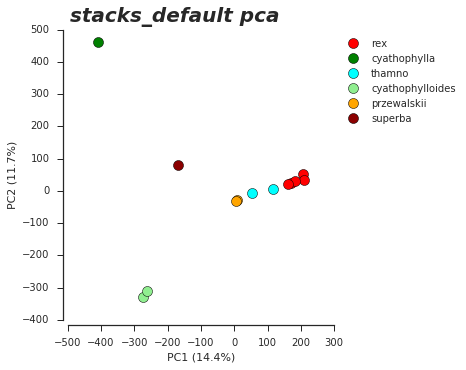

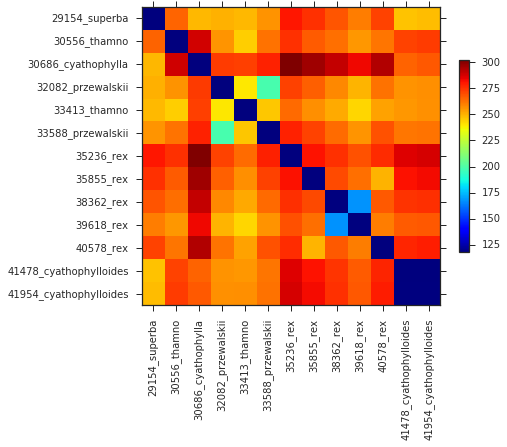

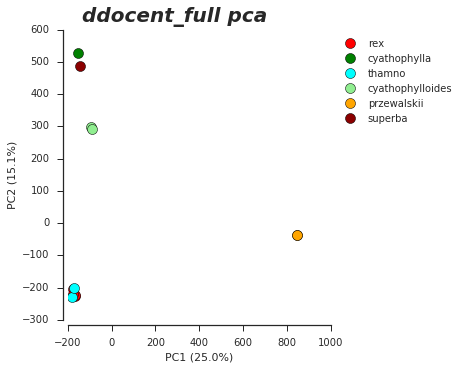

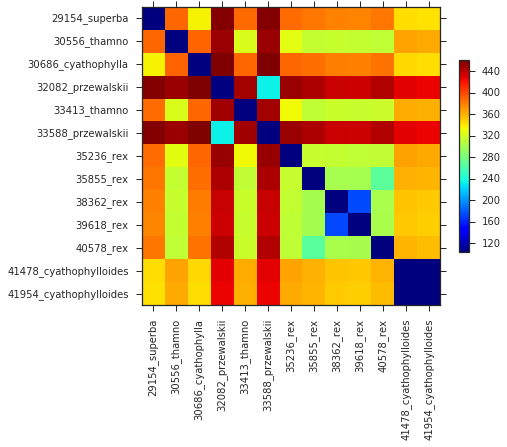

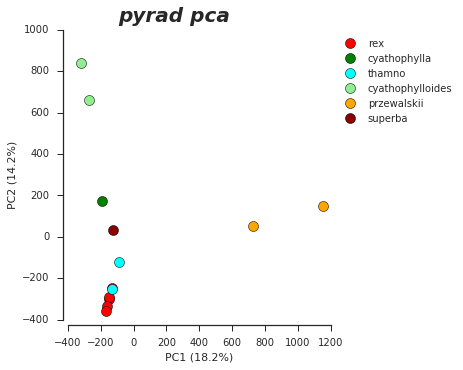

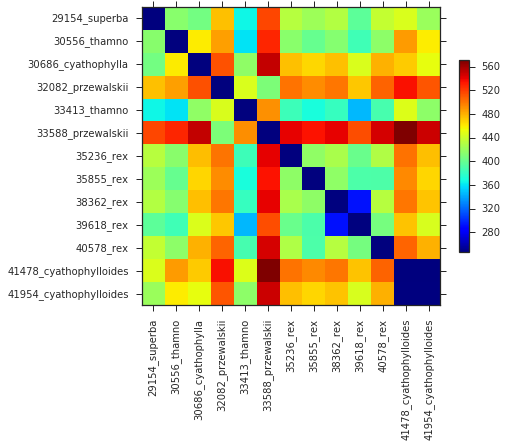

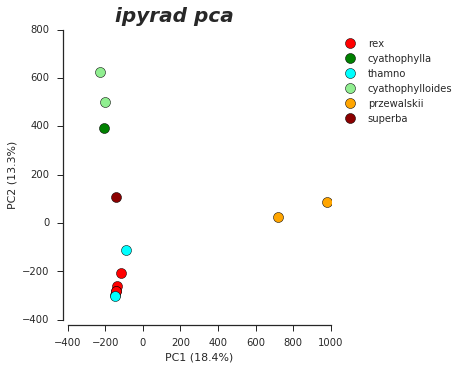

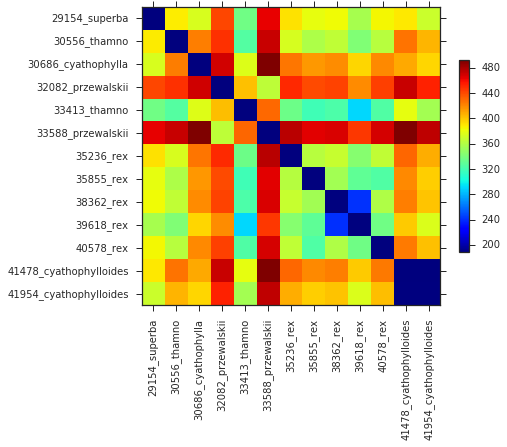

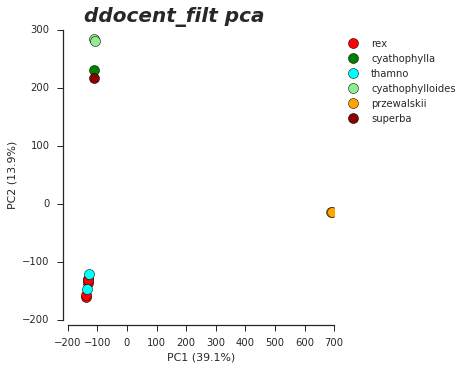

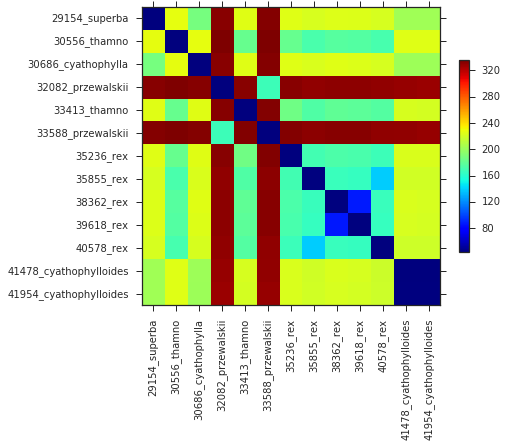

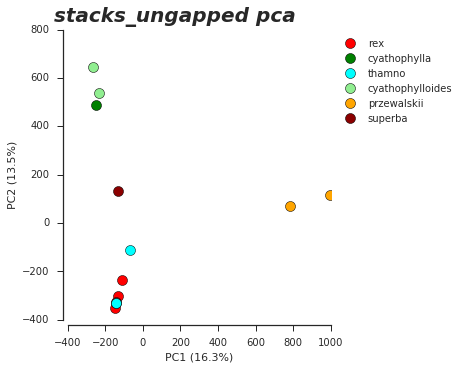

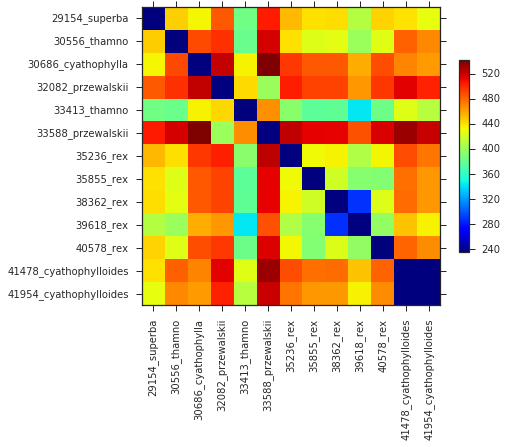

In [604]:
emp_loc_cov = collections.OrderedDict()
emp_snp_cov = collections.OrderedDict()
emp_sample_nsnps = collections.OrderedDict()
emp_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in vcf_dict.items():
    try:
        print("Doing - {}".format(prog))
        print("\t{}".format(filename))
        v = vcfnp.variants(filename, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename).view(np.recarray)

        emp_loc_cov[prog] = loci_coverage(v, c, prog)
        emp_snp_cov[prog] = snp_coverage(c)
        emp_sample_nsnps[prog] = sample_nsnps(c)
        emp_sample_nlocs[prog] = sample_nloci(v, c, prog)
        
        plotPCA(c, prog)
        plotPairwiseDistance(c, prog)
    except Exception as inst:
        print(inst)

In [608]:
for i in emp_sample_nlocs:
    print(i),
    print(emp_sample_nlocs[i])

stacks_default [22215, 32074, 25377, 16640, 23557, 17426, 32172, 34354, 31333, 29809, 34792, 24791, 25256]
ddocent_full [34816, 37668, 35523, 25583, 36635, 25751, 38051, 39179, 38946, 38744, 39209, 37612, 37240]
pyrad [22826, 34866, 30179, 19710, 19076, 21977, 36830, 36774, 37212, 29720, 38012, 35350, 31155]
ipyrad [18710, 28396, 24635, 15667, 15301, 17830, 29885, 29492, 30213, 24043, 30671, 29076, 25580]
ddocent_filt [18640, 18904, 18745, 18471, 18713, 18553, 18969, 19050, 19096, 19068, 19086, 19182, 19164]
stacks_ungapped [23103, 35494, 30792, 19377, 19547, 21469, 36663, 36949, 36703, 29789, 37968, 33544, 31931]


## ipyrad Empirical results
First we load in the variant info and call data for all the snps

In [70]:
IPYRAD_EMPIRICAL_OUTPUT=os.path.join(IPYRAD_DIR, "REALDATA/")
IPYRAD_STATS = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA_stats.txt")

infile = open(IPYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[20:33]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[21163, 31863, 27902, 20852, 17779, 23008, 33289, 33697, 35765, 29184, 35096, 38144, 34746]
mean sample coverage - 29422.1538462
min/max - 17779/38144


Read the biallelic vcf

In [71]:
filename = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA.biallelic.vcf")
# filename = vcf_dict["ipyrad"]
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 12:42:26.099077 :: caching is disabled
[vcfnp] 2016-10-12 12:42:26.099836 :: building array
[vcfnp] 2016-10-12 12:42:29.441796 :: caching is disabled
[vcfnp] 2016-10-12 12:42:29.442748 :: building array


### Distribution of snps along loci
Getting variable sites and parsimony informative sites from the vcf is kind of annoying
because all the programs export __slightly__ different formats, so you need to
parse them in slightly different ways. There's a better way to do this for ipyrad
but i figure i'll do it the same way for all of them so it's more clear what's happening.

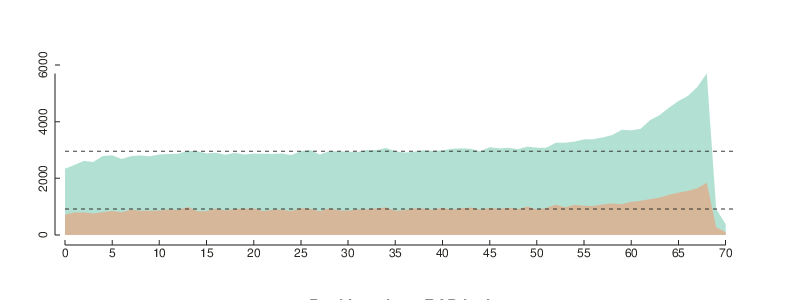

In [72]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x) for x in v.POS])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

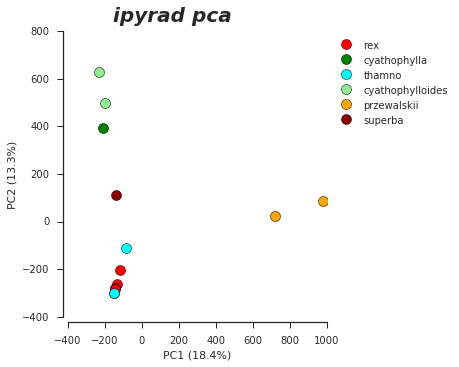

In [113]:
## Have to gunzip the ipyrad REALDATA vcf
plotPCA(c, "ipyrad")

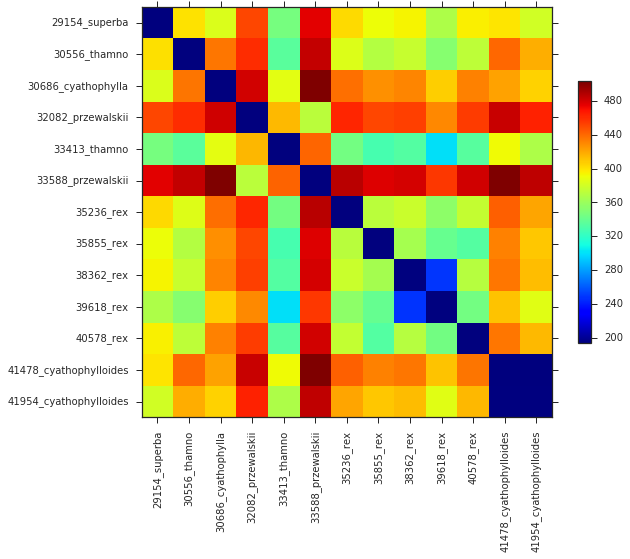

In [114]:
plotPairwiseDistance(c, "pyrad")

## pyRAD empirical results

#### TODO: Figure out why vcfnp is failing to read in pyrad vcf

In [206]:
PYRAD_EMPIRICAL_OUTPUT=os.path.join(PYRAD_DIR, "REALDATA/")
PYRAD_STATS = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "stats/c85d6m2p3H3N3.stats")

infile = open(PYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[8:21]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[23924, 37002, 31852, 23698, 20063, 26050, 38931, 39423, 41250, 33230, 40809, 42948, 38645]
mean sample coverage - 33678.8461538
min/max - 20063/42948


### Pull in the pyrad vcf
Be careful because sometimes the pyrad vcf gets a newline inserted between the last
line of metadata and the first line of genotypes, which causes vcfnp to silently fail.
Also there are a couple flags you can pass to vcfnp for debugging, but the print 
hella data to the console.

    v = vcfnp.variants(filename, progress=1, verbose=True).view(np.recarray)

In [230]:
filename = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-08 15:40:30.499958 :: caching is disabled
[vcfnp] 2016-10-08 15:40:30.500883 :: building array
[vcfnp] 2016-10-08 15:40:37.399061 :: caching is disabled
[vcfnp] 2016-10-08 15:40:37.417059 :: building array


### Distribution of snps along loci

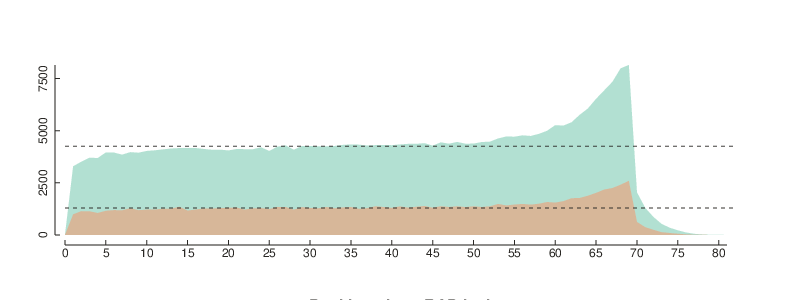

In [231]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x) for x in v.POS])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

## stacks empirical results (ungapped)

In [12]:
STACKS_OUTPUT=os.path.join(STACKS_DIR, "REALDATA/")
STACKS_GAP_OUT=os.path.join(STACKS_OUTPUT, "gapped/")
STACKS_UNGAP_OUT=os.path.join(STACKS_OUTPUT, "ungapped/")
STACKS_DEFAULT_OUT=os.path.join(STACKS_OUTPUT, "default/")

#lines = open("SIMsmall/stackf_high/batch_1.haplotypes.tsv").readlines()
#cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
#shigh = [cnts.count(i) for i in range(1,13)]

In [13]:
filename = os.path.join(STACKS_UNGAP_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 10:48:17.512074 :: caching is disabled
[vcfnp] 2016-10-12 10:48:17.512879 :: building array
[vcfnp] 2016-10-12 10:48:25.055213 :: caching is disabled
[vcfnp] 2016-10-12 10:48:25.061273 :: building array


### Distribution of snps along loci

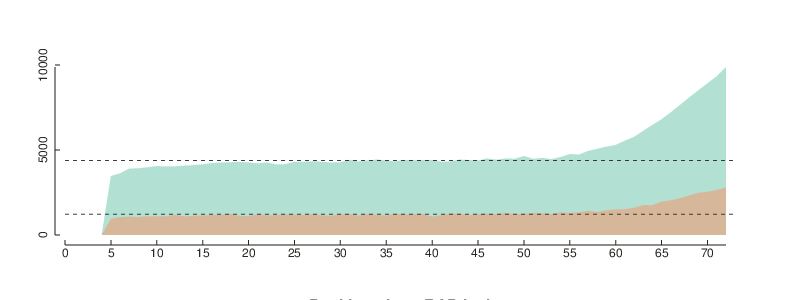

In [14]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["ID"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x.split("_")[1]) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x.split("_")[1]) for x in v.ID])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

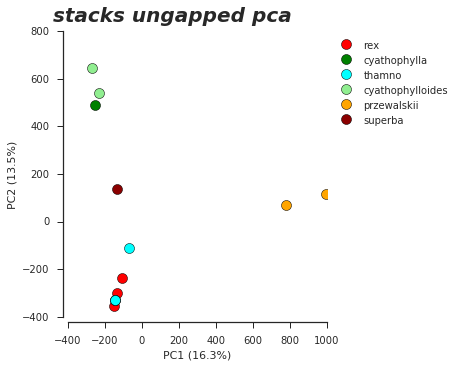

In [15]:
plotPCA(c, "stacks ungapped")

[vcfnp] 2016-09-03 19:04:05.829749 :: caching is disabled
[vcfnp] 2016-09-03 19:04:05.830278 :: building array


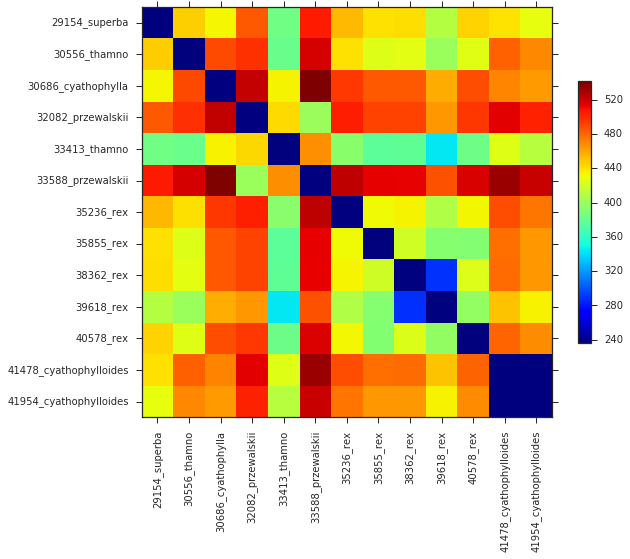

In [16]:
plotPairwiseDistance(c, "stacks ungapped")

## stacks empirical results (defaults)

In [16]:
filename = os.path.join(STACKS_DEFAULT_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 10:53:17.257960 :: caching is disabled
[vcfnp] 2016-10-12 10:53:17.259180 :: building array
[vcfnp] 2016-10-12 10:53:20.403885 :: caching is disabled
[vcfnp] 2016-10-12 10:53:20.409034 :: building array


### Some informative stats
TODO

### Distribution of snps along loci

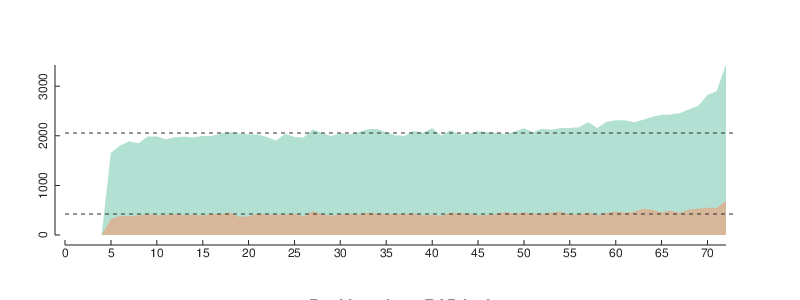

In [17]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["ID"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x.split("_")[1]) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x.split("_")[1]) for x in v.ID])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
toyplot.html.render(canvas, 'snp_positions.html')

canvas

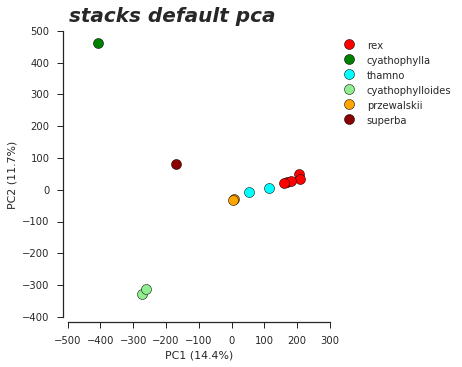

In [18]:
plotPCA(c, "stacks default")

[vcfnp] 2016-09-03 18:56:31.855138 :: caching is disabled
[vcfnp] 2016-09-03 18:56:31.855756 :: building array


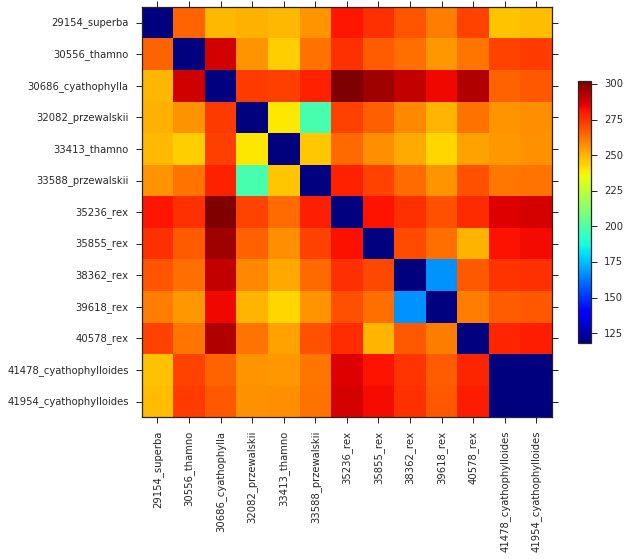

In [12]:
plotPairwiseDistance(c, "stacks default")

## AftrRAD empirical results

In [ ]:
AFTRRAD_OUTPUT=os.path.join(AFTRRAD_DIR, "REALDATA/")

In [ ]:
filename = os.path.join(STACKS_DEFAULT_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

### Distribution of snps along loci
NOT TESTED

It's not very straightforward how to extract information about
whether each snp is informative or not, given the output files
that aftrRAD generates. It does create a file with all the snp
locations so we can use this to generate the distribution of 
variable sites, but the pis will be empty.

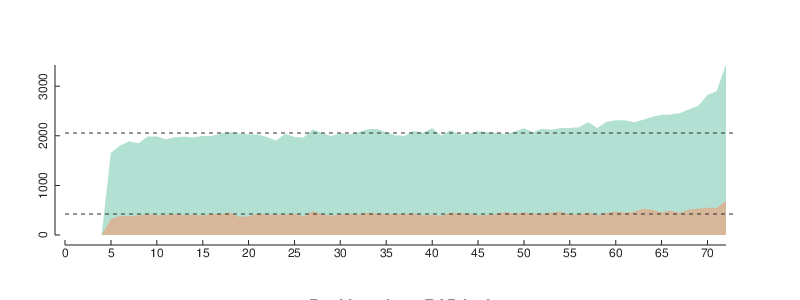

In [184]:
f = os.path.join(AFTRRAD_OUTPUT, "TempFiles/SNPLocationsToPlot.txt")
with open(f) as infile:
    snplocs = infile.read().split()
## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([])

## Getting the distvar is easier
distvar = Counter(map(int, snplocs))

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
## toyplot.html.render(canvas, 'snp_positions.html')

canvas

## dDocent empirical results
HAVE TO MAKE SURE THE SAMPLES IN THE DDOCENT OUTPUT VCF ARE IN THE SAME ORDER AS THOSE IN THE IPYRAD/STACKS
There is now code in the horserace notebook to rename samples in the ddocent
vcf and to reorder the samples to match ipyrad/stacks.

In [ ]:
import subprocess

DDOCENT_OUTPUT=os.path.join(DDOCENT_DIR, "REALDATA/")
os.chdir(DDOCENT_OUTPUT)
print("Getting max loci per sample from bam files.")
sample_coverage = []
for samp in glob.glob("*-RG.bam"):
    cmd = "{}samtools view {} | cut -f 3 | uniq | wc -l".format(DDOCENT_DIR, samp)
    res = subprocess.check_output(cmd, shell=True)
    print("nloci {} - {}".format(res.strip(), samp))
    sample_coverage.append(int(res.strip()))
    
print(sorted(sample_coverage, reverse=True))
    
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
#sim_coverage_df["ddocent_"+sim] = sample_coverage
    
vcf_filt = pd.read_csv("Final.recode.vcf", delim_whitespace=True, header=60, index_col=0)
vcf_full = pd.read_csv("TotalRawSNPs.vcf", delim_whitespace=True, header=60, index_col=0)

## There's gotta be a faster way to do this...
## It's really fuckin slow on real data, like hours.
for vcf in [vcf_full, vcf_filt]:
    sample_counts = {}
    sample_names = list(vcf.columns)[8:]
    print(sample_names)
    print("num loci in vcf - {}".format(len(set(vcf.index))))
    for name in sample_names:
        print(name)
        sample_counts[name] = 0
        for locus in set(vcf.index):
            snps = vcf[name][locus]
            if any(map(lambda x: x.split(":")[0] != "./.", snps)):
                sample_counts[name] += 1
            else:
                pass
    print(sample_counts)
print(sim_coverage_df)

Getting max loci per sample from bam files.
nloci 37358 - Pop1_Sample1-RG.bam
nloci 41001 - Pop3_Sample1-RG.bam
nloci 29663 - Pop2_Sample2-RG.bam
nloci 42706 - Pop3_Sample2-RG.bam
nloci 29490 - Pop2_Sample1-RG.bam
nloci 38202 - Pop4_Sample2-RG.bam
nloci 42543 - Pop3_Sample3-RG.bam
nloci 42667 - Pop3_Sample4-RG.bam
nloci 42999 - Pop3_Sample5-RG.bam
nloci 43950 - Pop4_Sample1-RG.bam
nloci 44300 - Pop4_Sample3-RG.bam
nloci 40740 - Pop5_Sample1-RG.bam
nloci 39368 - Pop5_Sample2-RG.bam
[44300, 43950, 42999, 42706, 42667, 42543, 41001, 40740, 39368, 38202, 37358, 29663, 29490]
mean sample coverage - 39614.3846154
min/max - 29490/44300


In [171]:
## Basic difference btw Final.recode and TotalRawSNPs is that final recode
## only includes individuals with snps called in > 90% of samples

f1 = os.path.join(DDOCENT_OUTPUT, "TotalRawSNPs.vcf")
v_full = vcfnp.variants(f1, dtypes={"CHROM":"a24"}).view(np.recarray)
c_full = vcfnp.calldata_2d(f1).view(np.recarray)
f2 = os.path.join(DDOCENT_OUTPUT, "Final.recode.vcf")
v_filt = vcfnp.variants(f2, dtypes={"CHROM":"a24"}).view(np.recarray)
c_filt = vcfnp.calldata_2d(f2).view(np.recarray)

[vcfnp] 2016-10-15 15:13:53.339632 :: caching is disabled
[vcfnp] 2016-10-15 15:13:53.340435 :: building array
[vcfnp] 2016-10-15 15:14:20.818988 :: caching is disabled
[vcfnp] 2016-10-15 15:14:20.832036 :: building array
[vcfnp] 2016-10-15 15:15:48.271026 :: caching is disabled
[vcfnp] 2016-10-15 15:15:48.272360 :: building array
[vcfnp] 2016-10-15 15:15:59.214829 :: caching is disabled
[vcfnp] 2016-10-15 15:15:59.224579 :: building array


### Distribution of snps along loci

In [75]:
for dset in [[v_full, c_full], [v_filt, c_filt]]:
    ## Get only parsimony informative sites
    ## Get T/F values for whether each genotype is ref or alt across all samples/loci
    is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), dset[1]["genotype"])
    ## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
    alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
    ## Create a T/F mask for snps that are informative
    only_pis = map(lambda x: x < 2, alt_counts)
    ## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
    ## Also, compress() the masked array so we only actually see the pis
    pis = np.ma.array(np.array(dset[0]["POS"]), mask=only_pis).compressed()

    ## Now have to massage this into the list of counts per site in increasing order 
    ## of position across the locus
    distpis = Counter([int(x) for x in pis])

    ## Getting the distvar is easier
    distvar = Counter([int(x) for x in v_filt.POS])

    canvas, axes = SNP_position_plot(distvar, distpis)

    ## save fig
    ## toyplot.html.render(canvas, 'snp_positions.html')

    canvas

<polygon points="65.0,235.0 73.933333333333337,235.0 82.866666666666674,235.0 91.799999999999997,235.0 100.73333333333333,235.0 109.66666666666666,235.0 118.60000000000001,235.0 127.53333333333333,235.0 136.46666666666667,235.0 145.40000000000001,235.0 154.33333333333334,235.0 163.26666666666665,235.0 172.20000000000002,235.0 181.13333333333333,235.0 190.06666666666669,235.0 199.0,235.0 207.93333333333334,235.0 216.86666666666667,235.0 225.80000000000001,235.0 234.73333333333335,235.0 243.66666666666669,235.0 252.60000000000002,235.0 261.5333333333333,235.0 270.46666666666664,235.0 279.40000000000003,235.0 288.33333333333331,235.0 297.26666666666665,235.0 306.19999999999999,235.0 315.13333333333338,235.0 324.06666666666666,235.0 333.0,235.0 341.93333333333334,235.0 350.86666666666667,235.0 359.79999999999995,235.0 368.73333333333335,235.0 377.66666666666669,235.0 386.60000000000002,235.0 395.53333333333336,235.0 404.4666666666667,235.0 413.39999999999998,235.0 422.33333333333331,235.0 431.26666666666665,235.0 440.20000000000005,235.0 449.13333333333338,235.0 458.06666666666666,235.0 467.0,235.0 475.93333333333328,235.0 484.86666666666667,235.0 493.80000000000001,235.0 502.73333333333335,235.0 511.66666666666669,235.0 520.60000000000002,235.0 529.5333333333333,235.0 538.4666666666667,235.0 547.39999999999998,235.0 556.33333333333337,235.0 565.26666666666677,235.0 574.20000000000005,235.0 583.13333333333333,235.0 592.06666666666661,235.0 601.0,235.0 609.93333333333339,235.0 618.86666666666667,235.0 627.79999999999995,235.0 636.73333333333335,235.0 645.66666666666663,235.0 654.59999999999991,235.0 663.5333333333333,235.0 672.4666666666667,235.0 681.40000000000009,235.0 690.33333333333337,235.0 699.26666666666665,235.0 708.20000000000005,235.0 717.13333333333344,235.0 726.06666666666672,235.0 726.06666666666672,147.54668930390494 717.13333333333344,156.92699490662136 708.20000000000005,145.16553480475383 699.26666666666665,137.58913412563666 690.33333333333337,143.14516129032259 681.40000000000009,138.02207130730051 672.4666666666667,136.57894736842104 663.5333333333333,133.98132427843802 654.59999999999991,132.17741935483872 645.66666666666663,126.40492359932088 636.73333333333335,134.48641765704582 627.79999999999995,131.74448217317487 618.86666666666667,126.91001697792871 609.93333333333339,134.63073005093378 601.0,132.46604414261461 592.06666666666661,127.48726655348048 583.13333333333333,133.47623089983023 574.20000000000005,128.13667232597624 565.26666666666677,121.64261460101869 556.33333333333337,133.54838709677418 547.39999999999998,126.76570458404075 538.4666666666667,125.75551782682513 529.5333333333333,125.89983022071308 520.60000000000002,123.08573853989813 511.66666666666669,122.50848896434636 502.73333333333335,132.10526315789474 493.80000000000001,126.98217317487268 484.86666666666667,130.80645161290323 475.93333333333328,134.12563667232598 467.0,124.81748726655348 458.06666666666666,122.58064516129033 449.13333333333338,132.03310696095076 440.20000000000005,126.40492359932088 431.26666666666665,124.31239388794569 422.33333333333331,131.31154499151103 413.39999999999998,136.00169779286927 404.4666666666667,126.83786078098471 395.53333333333336,130.51782682512732 386.60000000000002,128.56960950764005 377.66666666666669,122.3641765704584 368.73333333333335,134.77504244482174 359.79999999999995,127.99235993208829 350.86666666666667,129.79626485568761 341.93333333333334,137.58913412563666 333.0,132.89898132427842 324.06666666666666,126.54923599320882 315.13333333333338,133.40407470288625 306.19999999999999,134.63073005093378 297.26666666666665,129.94057724957557 288.33333333333331,134.5585738539898 279.40000000000003,131.02292020373517 270.46666666666664,127.34295415959252 261.5333333333333,132.24957555178267 252.60000000000002,129.94057724957557 243.66666666666669,123.37436332767402 234.73333333333335,131.52801358234296 225.80000000000001,135.1358234295416 216.86666666666667,129.94057724957557 207.93333333333334,136.6

<polygon points="65.0,235.0 73.933333333333337,235.0 82.866666666666674,235.0 91.799999999999997,235.0 100.73333333333333,235.0 109.66666666666666,235.0 118.60000000000001,235.0 127.53333333333333,235.0 136.46666666666667,235.0 145.40000000000001,235.0 154.33333333333334,235.0 163.26666666666665,235.0 172.20000000000002,235.0 181.13333333333333,235.0 190.06666666666669,235.0 199.0,235.0 207.93333333333334,235.0 216.86666666666667,235.0 225.80000000000001,235.0 234.73333333333335,235.0 243.66666666666669,235.0 252.60000000000002,235.0 261.5333333333333,235.0 270.46666666666664,235.0 279.40000000000003,235.0 288.33333333333331,235.0 297.26666666666665,235.0 306.19999999999999,235.0 315.13333333333338,235.0 324.06666666666666,235.0 333.0,235.0 341.93333333333334,235.0 350.86666666666667,235.0 359.79999999999995,235.0 368.73333333333335,235.0 377.66666666666669,235.0 386.60000000000002,235.0 395.53333333333336,235.0 404.4666666666667,235.0 413.39999999999998,235.0 422.33333333333331,235.0 431.26666666666665,235.0 440.20000000000005,235.0 449.13333333333338,235.0 458.06666666666666,235.0 467.0,235.0 475.93333333333328,235.0 484.86666666666667,235.0 493.80000000000001,235.0 502.73333333333335,235.0 511.66666666666669,235.0 520.60000000000002,235.0 529.5333333333333,235.0 538.4666666666667,235.0 547.39999999999998,235.0 556.33333333333337,235.0 565.26666666666677,235.0 574.20000000000005,235.0 583.13333333333333,235.0 592.06666666666661,235.0 601.0,235.0 609.93333333333339,235.0 618.86666666666667,235.0 627.79999999999995,235.0 636.73333333333335,235.0 645.66666666666663,235.0 654.59999999999991,235.0 663.5333333333333,235.0 672.4666666666667,235.0 681.40000000000009,235.0 690.33333333333337,235.0 699.26666666666665,235.0 708.20000000000005,235.0 717.13333333333344,235.0 726.06666666666672,235.0 726.06666666666672,110.729794933655 717.13333333333344,124.05910735826296 708.20000000000005,107.34620024125454 699.26666666666665,96.580217129071173 690.33333333333337,104.47527141133895 681.40000000000009,97.195416164053086 672.4666666666667,95.144752714113395 663.5333333333333,91.453558504221945 654.59999999999991,88.890229191797346 645.66666666666663,80.68757539203861 636.73333333333335,92.171290711700863 627.79999999999995,88.275030156815433 618.86666666666667,81.405307599517485 609.93333333333339,92.376357056694815 601.0,89.300361881785278 592.06666666666661,82.225572979493364 583.13333333333333,90.735826296743056 574.20000000000005,83.14837153196622 565.26666666666677,73.920386007237639 556.33333333333337,90.838359469240061 547.39999999999998,81.200241254523533 538.4666666666667,79.764776839565741 529.5333333333333,79.969843184559707 520.60000000000002,75.97104945717733 511.66666666666669,75.15078407720145 502.73333333333335,88.78769601930037 493.80000000000001,81.507840772014475 484.86666666666667,86.942098914354659 475.93333333333328,91.658624849215926 467.0,78.431845597104953 458.06666666666666,75.253317249698441 449.13333333333338,88.685162846803365 440.20000000000005,80.68757539203861 431.26666666666665,77.71411338962605 422.33333333333331,87.659831121833534 413.39999999999998,94.324487334137501 404.4666666666667,81.302774427020509 395.53333333333336,86.531966224366727 386.60000000000002,83.763570566948118 377.66666666666669,74.94571773220747 368.73333333333335,92.581423401688795 359.79999999999995,82.943305186972253 350.86666666666667,85.506634499396867 341.93333333333334,96.580217129071173 333.0,89.915560916767191 324.06666666666666,80.892641737032577 315.13333333333338,90.63329312424608 306.19999999999999,92.376357056694815 297.26666666666665,85.711700844390833 288.33333333333331,92.273823884197824 279.40000000000003,87.249698431845601 270.46666666666664,82.020506634499412 261.5333333333333,88.992762364294322 252.60000000000002,85.711700844390833 243.66666666666669,76.381182147165262 234.73333333333335,87.967430639324476 225.80000000000001,93.094089264173704 216.86666666666667,85.711700844390833 207.93333333333334,95.2472858866

In [82]:
#Tmp delete me
print(np.sum(distvar.values()))
print(np.sum(distpis.values()))

99971
60996


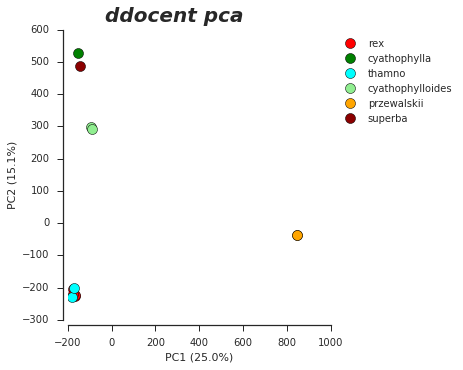

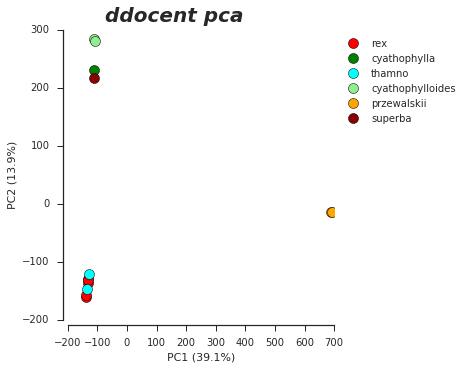

In [238]:
for dset in [[v_full, c_full], [v_filt, c_filt]]:
    plotPCA(dset[1], "ddocent")

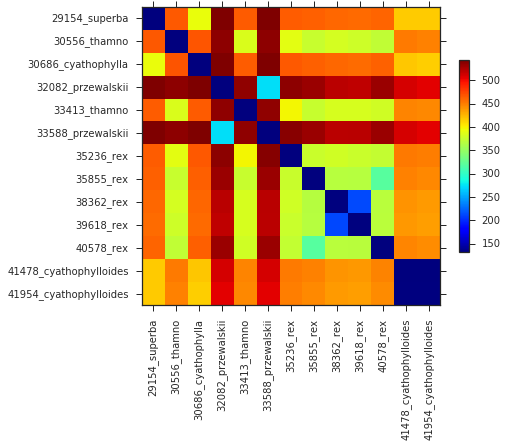

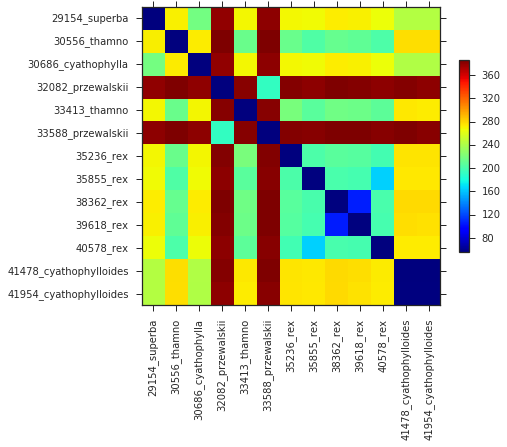

In [239]:
plotPairwiseDistance(c_full, "dDocent Full")
plotPairwiseDistance(c_filt, "dDocent Filtered")

# Everything Below here is crap!

In [584]:
## Testing for different vcf formats
prog = "stacks-simhi"
filename = "/home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/simhi/batch_1.vcf"
#prog = "dDocent-simhi"
#filename = "/home/iovercast/manuscript-analysis/dDocent/SIMDATA/simhi/simhi_fastqs/TotalRawSNPs.vcf"
#prog = "ipyrad-simlarge"
#filename = "/home/iovercast/manuscript-analysis/ipyrad/SIMDATA/simlarge/simlarge_outfiles/simlarge-biallelic.recode.vcf"
prog = "pyrad-simhi"
filename = "/home/iovercast/manuscript-analysis/pyrad/SIMDATA/simhi/outfiles/c85d6m2p3H3N3.vcf"
v = vcfnp.variants(filename, dtypes={"CHROM":"a24"}).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

print("loc_cov", loci_coverage(v, c, prog))
print("snp_cov", snp_coverage(c))
print("snps", sample_nsnps(c))
print("nlocs", sample_nloci(v, c, prog))

[vcfnp] 2016-10-17 14:32:50.401685 :: caching is disabled
[vcfnp] 2016-10-17 14:32:50.402203 :: building array
[vcfnp] 2016-10-17 14:32:50.880046 :: caching is disabled
[vcfnp] 2016-10-17 14:32:50.880506 :: building array


('loc_cov', [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 9881])
('snp_cov', [1, 10, 6, 6, 1, 14, 0, 10, 7, 6, 61, 43054])
('snps', [43139, 43139, 43135, 43141, 43134, 43139, 43139, 43139, 43144, 43141, 43143, 43141])
('nlocs', [9883, 9883, 9883, 9883, 9883, 9882, 9883, 9883, 9883, 9883, 9883, 9883])


# Everything Below here is crap!

# Everything Below here is crap!

In [49]:
## Maybe useful
print(v.ID)
print(len(v.ID))
print(len(set([x.split("_")[0] for x in v.ID])))


['1_6' '1_14' '1_27' ..., '614361_45' '614386_71' '614406_58']
344633
76984


In [37]:
import itertools
import numpy.ma as ma
print(v.ID)
print(len(v.ID))
loc_list = []
loci = set([x.split("_")[0] for x in v.ID])
print(len(loci))
loc_list = [list(val) for key,val in itertools.groupby(v.ID,key=lambda x:x.split("_")[0])]

print(len(loc_list))
## experimentation
print(v.dtype)
print(c.dtype)

print(np.mean(c.DP))
print(loc_list[0:10])
subsamp = np.array([np.random.choice(x, 1, replace=False)[0] for x in loc_list])
mask = np.in1d(v.ID, subsamp)

['4_35' '4_62' '5_56' ..., '496594_58' '496602_66' '496604_59']
149570
82955
82955
(numpy.record, [('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AF', '<f2'), ('NS', '<i4')])
(numpy.record, [('is_called', '?'), ('is_phased', '?'), ('genotype', 'i1', (2,)), ('AD', '<u2', (2,)), ('DP', '<u2'), ('GL', '<f4'), ('GT', 'S3')])
5.95418198837
[['4_35', '4_62'], ['5_56', '5_62', '5_68'], ['6_61', '6_68'], ['7_67'], ['8_5', '8_41', '8_65'], ['11_40'], ['13_49', '13_71'], ['15_6', '15_10', '15_24', '15_34'], ['16_26'], ['17_17', '17_26', '17_27', '17_66']]


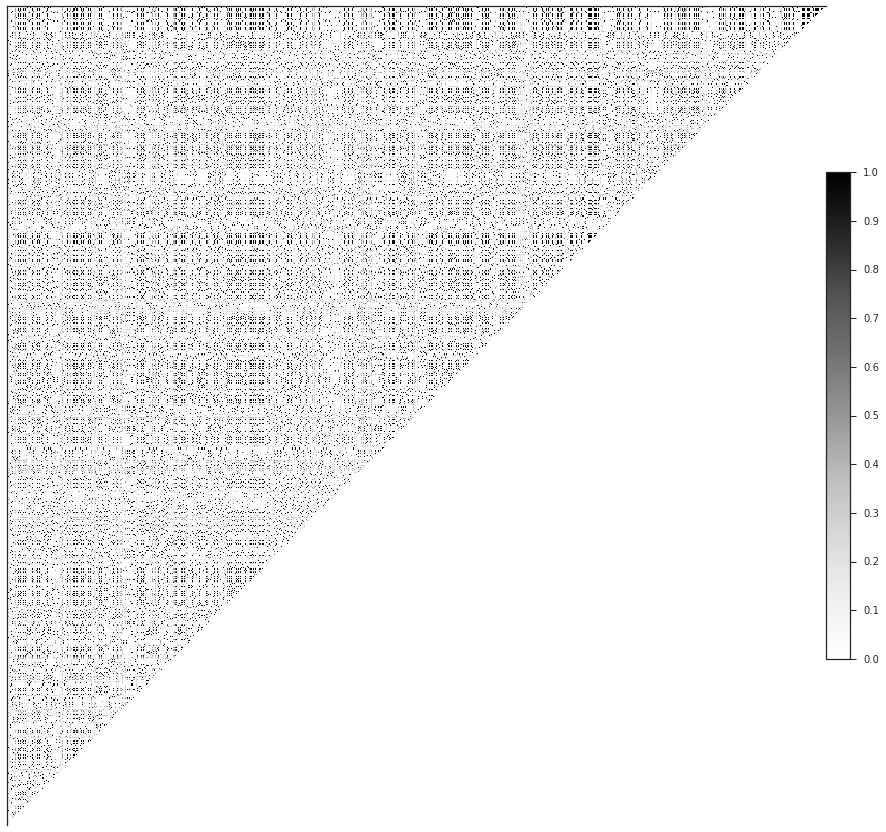

In [55]:
g = allel.GenotypeArray(cmask.genotype)
gn = g.to_n_alt()
m = allel.stats.rogers_huff_r(gn[:1000]) ** 2
ax = allel.plot.pairwise_ld(m)

In [ ]:
## Some crap from when i was counting loci a very stupid and slow way for stacks.
        ### This doesn't' count monomorphics, but could be useful still. It's dog slow.
            #vcf = pd.read_csv("{}/batch_1.vcf".format(simdir), delim_whitespace=True, header=9, index_col=2)
            #sample_counts = {}
            #sample_names = list(vcf.columns)[8:]
            #print(sample_names)
            #uniq_loci = set([x.split("_")[0] for x in vcf.index])
            #print("num loci - {}".format(len(uniq_loci)))
            ## Replace the ID index in the stacks vcf file so we can actually evaluate loci
            #vcf.index = pd.Index([x.split("_")[0] for x in vcf.index])
            #for name in sample_names:
            #    print(name),
            #    sample_counts[name] = 0
            #    for locus in uniq_loci:
            #        snps = vcf[name][locus]
            #        if any(map(lambda x: x.split(":")[0] != "./.", snps)):
            #            sample_counts[name] += 1
            #        else:
            #            pass
            #        #print("{} {} {}".format(name, locus, snps))
            #print(sample_counts)
            #sim_full_sample_nlocs["stacks_"+stacks_method+"-"+sim] = sample_coverage
 

In [191]:
filename = os.path.join(DDOCENT_OUTPUT, "Final.recode.snps.vcf")
v_filt = vcfnp.variants(filename).view(np.recarray)
c_filt = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-06 21:43:30.965523 :: caching is disabled
[vcfnp] 2016-10-06 21:43:30.966488 :: building array
[vcfnp] 2016-10-06 21:43:42.021230 :: caching is disabled
[vcfnp] 2016-10-06 21:43:42.029759 :: building array


In [220]:
from collections import Counter
print(v_filt.dtype)
#wat = Counter(vcall["POS"])
#wat
## DDOCENT
v_filt["is_snp"]
print(v_filt[0:2])
print(v_filt["NS"][:40])
print(v_filt["NUMALT"][:40])
print(v_filt["ALT"][:40])
loci = set(v_filt["CHROM"])


(numpy.record, [('CHROM', 'S24'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AB', '<f4'), ('ABP', '<f4'), ('AC', '<u2'), ('AF', '<f2'), ('AN', '<u2'), ('AO', '<i4'), ('CIGAR', 'S12'), ('DP', '<i4'), ('DPB', '<f4'), ('DPRA', '<f4'), ('END', '<i4'), ('EPP', '<f4'), ('EPPR', '<f4'), ('GTI', '<i4'), ('LEN', '<i4'), ('MEANALT', '<f4'), ('MIN_DP', '<i4'), ('MQM', '<f4'), ('MQMR', '<f4'), ('NS', '<i4'), ('NUMALT', '<i4'), ('ODDS', '<f4'), ('PAIRED', '<f4'), ('PAIREDR', '<f4'), ('PAO', '<f4'), ('PQA', '<f4'), ('PQR', '<f4'), ('PRO', '<f4'), ('QA', '<i4'), ('QR', '<i4'), ('RO', '<i4'), ('RPL', '<f4'), ('RPP', '<f4'), ('RPPR', '<f4'), ('RPR', '<f4'), ('RUN', '<i4'), ('SAF', '<i4'), ('SAP', '<f4'), ('SAR', '<i4'), ('SRF', '<i4'), ('SRP', '<f4'), ('SRR', '<i4'), ('TYPE', 'S12'), ('technology.Illumina', '<f4')])
[ ('dDocent_Contig_1', 7, '.', 'T', 'A', 9108.900390625, (False

In [200]:
print(c.dtype)
print(len(c))
print(c["GT"][0:10][:,0])
print((c["GT"][0:10000][:,0] == "./.").sum())

print(c["GT"][0:5] != "./.")
print((x != "./.").sum() for x in c["GT"][0:5])

from collections import Counter

loci_coverage = [x.sum() for x in c_filt["GT"].T != "./."]
print(loci_coverage)

(numpy.record, [('is_called', '?'), ('is_phased', '?'), ('genotype', 'i1', (2,)), ('CATG', 'S12'), ('GT', 'S3')])
220118
['./.' './.' './.' './.' './.' './.' './.' './.' '0/0' '0/0']
5811
[[False False False False False False False  True False False False  True
  False]
 [False False False False False False False  True False False False  True
  False]
 [False False False False  True False False False  True False False False
  False]
 [False False False False  True False False False  True False False False
  False]
 [False False False False  True False False False  True False False False
  False]]
<generator object <genexpr> at 0x2aab77fca870>
[96757, 98257, 97393, 95620, 97197, 95823, 98629, 98982, 99257, 99071, 99157, 99736, 99578]


In [599]:
#x = sim_loc_cov
#x = sim_snp_cov
#x = sim_sample_nsnps
x = sim_sample_nlocs
for sim in ["-simno", "-simlo", "-simhi", "-simlarge"]:
    for prog in ["ipyrad", "pyrad", "stacks_ungapped", "stacks_gapped", "stacks_defualt", "ddocent_filt", "ddocent_full", "aftrrad"]:
        try:
            print(prog+sim+"\t"),
            print(x[prog+sim]),
            print(np.mean(x[prog+sim]))
        except:
            print("No {}".format(prog+sim))
    print("------------------------------------------------------")

ipyrad-simno	[9870, 9870, 9870, 9870, 9870, 9870, 9870, 9870, 9870, 9870, 9870, 9870] 9870.0
pyrad-simno	[9894, 9894, 9894, 9894, 9894, 9894, 9894, 9894, 9894, 9894, 9894, 9894] 9894.0
stacks_ungapped-simno	[9870, 9862, 9865, 9863, 9862, 9864, 9864, 9867, 9865, 9867, 9863, 9865] 9864.75
stacks_gapped-simno	[9870, 9862, 9865, 9863, 9862, 9864, 9864, 9867, 9865, 9867, 9863, 9865] 9864.75
stacks_defualt-simno	[9320, 9303, 9253, 9096, 9042, 9021, 8958, 8934, 8846, 8823, 8767, 8687] 9004.16666667
ddocent_filt-simno	[9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852] 9852.0
ddocent_full-simno	[9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852, 9852] 9852.0
aftrrad-simno	No aftrrad-simno
------------------------------------------------------
ipyrad-simlo	[9859, 9859, 9859, 9859, 9859, 9859, 9859, 9859, 9859, 9859, 9859, 9859] 9859.0
pyrad-simlo	[9884, 9884, 9884, 9884, 9884, 9884, 9884, 9884, 9884, 9884, 9884, 9884] 9884.0
stacks_ungapped-simlo	[9819, 9808,

In [338]:
if True:
    keys   = ["e", "b", "b", "c", "d", "e", "e", 'a']
    values = [1.2, 4.5, 4.3, 2.0, 5.67, 8.08, 9.01,1]

    print('two methods of splitting by group')
    print('as list')
    for k,v in zip(*npi.group_by(keys)(values)):
        print(k, v)
    print('as iterable')
    g = npi.group_by(keys)
    for k,v in zip(g.unique, g.split_sequence_as_iterable(values)):
        print(k, list(v))
    print('iterable as iterable')
    for k, v in zip(g.unique, g.split_iterable_as_iterable(values)):
        print(k, list(v))


two methods of splitting by group
as list
('a', array([ 1.]))
('b', array([ 4.5,  4.3]))
('c', array([ 2.]))
('d', array([ 5.67]))
('e', array([ 1.2 ,  8.08,  9.01]))
as iterable
[1 2 1 1 3]
('a', [1])
('b', [4.5, 4.3])
('c', [2.0])
('d', [5.67])
('e', [1.2, 8.08, 9.01])
iterable as iterable
('a', [1])
('b', [4.5, 4.3])
('c', [2.0])
('d', [5.67])
('e', [1.2, 8.08, 9.01])
